# K Nearest Neighbor with Dynamic Time Warping

In [25]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

In [26]:
plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

In [36]:
class KnnDtw(object):
    # n_neighbors : Number of neighbors to use by default for KNN (default = 5)
    # max_warping_window : It is allowed by DTW dynamic programming function (default = infinity)
    # subsample_step : Step size for the time series array (default = 1)
    
    def __init__(self, n_neighbors = 5, max_warping_window = 10000, subsample_step = 1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    # Fit the model using x as training data and l as class labels
    def fit(self, x, l):
        self.x = x
        self.l = l
    
    # Returns the DTW similarity distance between two 2D time series numpy arrays
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M,N))
        
        # Initialize the first row and column
        cost[0,0] = d(ts_a[0], ts_b[0])
        for i in range(1,M):
            cost[i,0] = cost[i-1,0] + d(ts_a[i], ts_b[0])
        for j in range(1,N):
            cost[0,j] = cost[0,j-1] + d(ts_a[0], ts_b[j])
        
        # Populate rest of cost matrix within window
        for i in range(1,M):
            for j in range(max(1, i - self.max_warping_window),
                          min(N, i + self.max_warping_window)):
                choices  = cost[i-1, j-1], cost[i, j-1], cost[i-1, j]
                cost[i,j] = min(choices) + d(ts_a[i], ts_b[j])
        
        # Returns DTW distance given window
        return cost[-1,-1]
    
    # Compute the M x N distance matrix between the training dataset and testing dataset(y)
    # using the DTW distance measure
    def _dist_matrix(self, x, y):
        dm_count = 0
        
        # Compute condensed distance matrix of pairwise dtw distances when x and y are the same array
        if np.array_equal(x,y):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype = np.double)
            
            P = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                y[j, ::self.subsample_step])
                    dm_count += 1
                    p.animate(dm_count)
             
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distance between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0] * y_s[0]
            
            p = ProgressBar(dm_size)
            
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i,j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                y[j, ::self.subsample_step])
                    dm_count += 1
                    p.animate(dm_count)
                    
            return dm
        
    # Predict the class labels or probability estimates for the provided data
    def predict(self, x):
        dm = self._dist_matrix(x, self.x)
        
        knn_idx = dm.argsort()[:, :self.n_neighbors]
        knn_labels = self.l[knn_idx]
        
        mode_data = mode(knn_labels, axis=1, keepdims=True)
        mode_label = mode_data[0]
        mode_proba = mode_data[1] / self.n_neighbors
        
        return mode_label.ravel(), mode_proba.ravel()           

In [28]:
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython
            
    def animate_ipython(self, iter):
        print ('\r', self,
        sys.stdout.flush())
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar) 

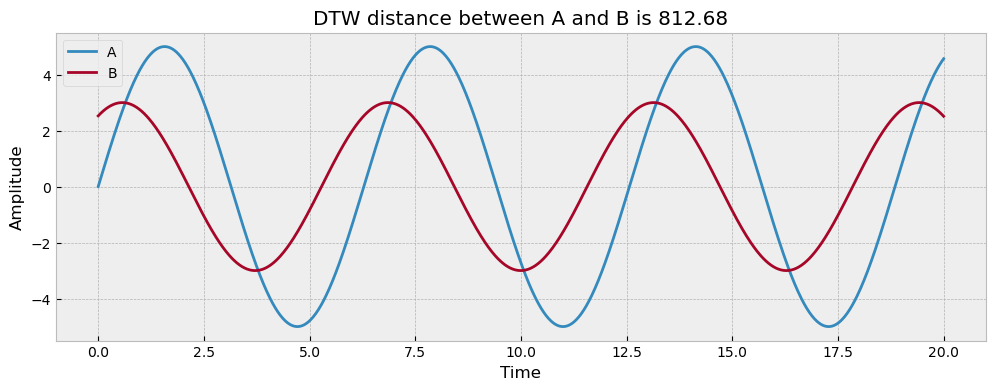

In [29]:
time = np.linspace(0, 20, 1000)
amplitude_a = 5 * np.sin(time)
amplitude_b = 3 * np.sin(time + 1)

m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)

fig = plt.figure(figsize=(12,4))
plt.plot(time, amplitude_a, label = 'A')
plt.plot(time, amplitude_b, label = 'B')
plt.title('DTW distance between A and B is %.2f' % distance)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.legend()

In [30]:
m._dist_matrix(np.random.randn(4,50), np.random.randn(4,50))

 [                  0%                  ] None
 [*****            12%                  ]  2 of 16 complete None
 [*******          19%                  ]  3 of 16 complete None
 [**********       25%                  ]  4 of 16 complete None
 [************     31%                  ]  5 of 16 complete None
 [**************   38%                  ]  6 of 16 complete None
 [*****************44%                  ]  7 of 16 complete None
 [*****************50%                  ]  8 of 16 complete None
 [*****************56%*                 ]  9 of 16 complete None
 [*****************62%****              ]  10 of 16 complete None
 [*****************69%******            ]  11 of 16 complete None
 [*****************75%********          ]  12 of 16 complete None
 [*****************81%***********       ]  13 of 16 complete None
 [*****************88%*************     ]  14 of 16 complete None
 [*****************94%****************  ]  15 of 16 complete None
 [****************100%***************

array([[35.89104356, 34.89999668, 32.47744968, 34.60081314],
       [27.93418341, 31.83490241, 33.55302889, 30.96097461],
       [32.50091398, 36.11928312, 32.40894418, 34.99000018],
       [40.68841601, 42.27195564, 32.8943541 , 36.87453745]])

In [31]:
# Import the HAR dataset
x_train_file = open('./Data/train/X_train.txt', 'r')
y_train_file = open('./Data/train/y_train.txt', 'r')

x_test_file = open('./Data/test/X_test.txt', 'r')
y_test_file = open('./Data/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

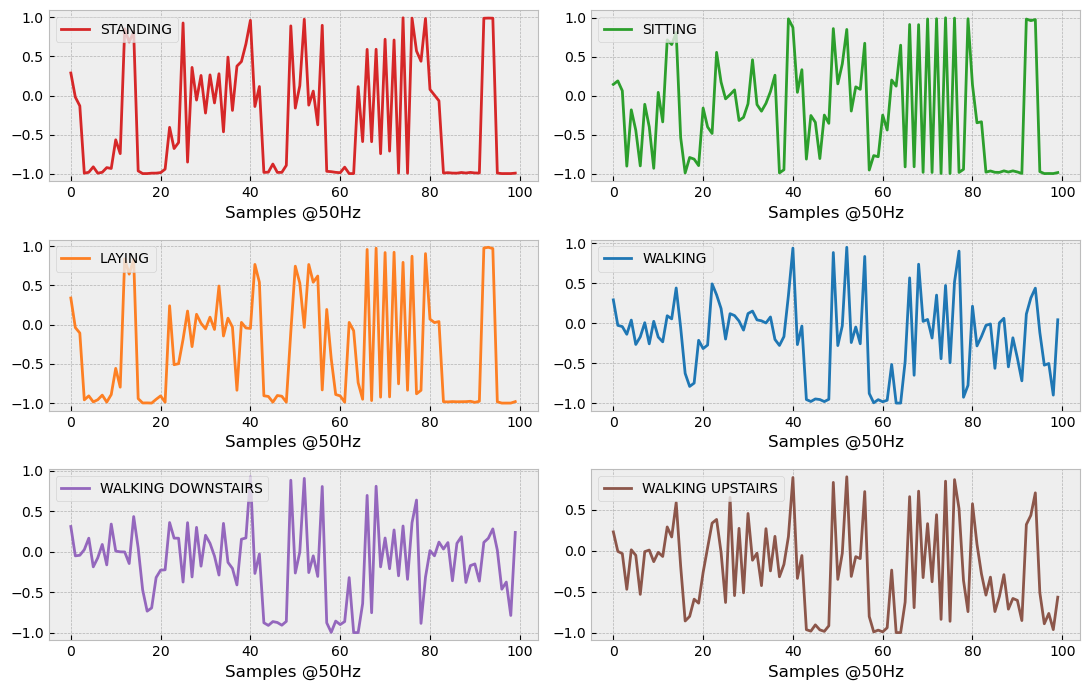

In [32]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([0,27,65,100,145,172]):
    plt.subplot(3,2,i+1)
    plt.plot(x_train[r][:100], label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('Samples @50Hz')
    plt.legend(loc='upper left')
    plt.tight_layout()

In [45]:
m = KnnDtw(n_neighbors=1, max_warping_window=10)
m.fit(x_train[::10], y_train[::10])
label, proba = m.predict(x_test[::100])

 [                  0%                  ] None
 [                  0%                  ]  2 of 22080 complete None
 [                  0%                  ]  3 of 22080 complete None
 [                  0%                  ]  4 of 22080 complete None
 [                  0%                  ]  5 of 22080 complete None
 [                  0%                  ]  6 of 22080 complete None
 [                  0%                  ]  7 of 22080 complete None
 [                  0%                  ]  8 of 22080 complete None
 [                  0%                  ]  9 of 22080 complete None
 [                  0%                  ]  10 of 22080 complete None
 [                  0%                  ]  11 of 22080 complete None
 [                  0%                  ]  12 of 22080 complete None
 [                  0%                  ]  13 of 22080 complete None
 [                  0%                  ]  14 of 22080 complete None
 [                  0%                  ]  15 of 22080 complete 

 [                  1%                  ]  120 of 22080 complete None
 [                  1%                  ]  121 of 22080 complete None
 [                  1%                  ]  122 of 22080 complete None
 [                  1%                  ]  123 of 22080 complete None
 [                  1%                  ]  124 of 22080 complete None
 [                  1%                  ]  125 of 22080 complete None
 [                  1%                  ]  126 of 22080 complete None
 [                  1%                  ]  127 of 22080 complete None
 [                  1%                  ]  128 of 22080 complete None
 [                  1%                  ]  129 of 22080 complete None
 [                  1%                  ]  130 of 22080 complete None
 [                  1%                  ]  131 of 22080 complete None
 [                  1%                  ]  132 of 22080 complete None
 [                  1%                  ]  133 of 22080 complete None
 [                  

 [                  1%                  ]  238 of 22080 complete None
 [                  1%                  ]  239 of 22080 complete None
 [                  1%                  ]  240 of 22080 complete None
 [                  1%                  ]  241 of 22080 complete None
 [                  1%                  ]  242 of 22080 complete None
 [                  1%                  ]  243 of 22080 complete None
 [                  1%                  ]  244 of 22080 complete None
 [                  1%                  ]  245 of 22080 complete None
 [                  1%                  ]  246 of 22080 complete None
 [                  1%                  ]  247 of 22080 complete None
 [                  1%                  ]  248 of 22080 complete None
 [                  1%                  ]  249 of 22080 complete None
 [                  1%                  ]  250 of 22080 complete None
 [                  1%                  ]  251 of 22080 complete None
 [                  

 [*                 2%                  ]  356 of 22080 complete None
 [*                 2%                  ]  357 of 22080 complete None
 [*                 2%                  ]  358 of 22080 complete None
 [*                 2%                  ]  359 of 22080 complete None
 [*                 2%                  ]  360 of 22080 complete None
 [*                 2%                  ]  361 of 22080 complete None
 [*                 2%                  ]  362 of 22080 complete None
 [*                 2%                  ]  363 of 22080 complete None
 [*                 2%                  ]  364 of 22080 complete None
 [*                 2%                  ]  365 of 22080 complete None
 [*                 2%                  ]  366 of 22080 complete None
 [*                 2%                  ]  367 of 22080 complete None
 [*                 2%                  ]  368 of 22080 complete None
 [*                 2%                  ]  369 of 22080 complete None
 [*                 

 [*                 2%                  ]  474 of 22080 complete None
 [*                 2%                  ]  475 of 22080 complete None
 [*                 2%                  ]  476 of 22080 complete None
 [*                 2%                  ]  477 of 22080 complete None
 [*                 2%                  ]  478 of 22080 complete None
 [*                 2%                  ]  479 of 22080 complete None
 [*                 2%                  ]  480 of 22080 complete None
 [*                 2%                  ]  481 of 22080 complete None
 [*                 2%                  ]  482 of 22080 complete None
 [*                 2%                  ]  483 of 22080 complete None
 [*                 2%                  ]  484 of 22080 complete None
 [*                 2%                  ]  485 of 22080 complete None
 [*                 2%                  ]  486 of 22080 complete None
 [*                 2%                  ]  487 of 22080 complete None
 [*                 

 [*                 3%                  ]  592 of 22080 complete None
 [*                 3%                  ]  593 of 22080 complete None
 [*                 3%                  ]  594 of 22080 complete None
 [*                 3%                  ]  595 of 22080 complete None
 [*                 3%                  ]  596 of 22080 complete None
 [*                 3%                  ]  597 of 22080 complete None
 [*                 3%                  ]  598 of 22080 complete None
 [*                 3%                  ]  599 of 22080 complete None
 [*                 3%                  ]  600 of 22080 complete None
 [*                 3%                  ]  601 of 22080 complete None
 [*                 3%                  ]  602 of 22080 complete None
 [*                 3%                  ]  603 of 22080 complete None
 [*                 3%                  ]  604 of 22080 complete None
 [*                 3%                  ]  605 of 22080 complete None
 [*                 

 [*                 3%                  ]  710 of 22080 complete None
 [*                 3%                  ]  711 of 22080 complete None
 [*                 3%                  ]  712 of 22080 complete None
 [*                 3%                  ]  713 of 22080 complete None
 [*                 3%                  ]  714 of 22080 complete None
 [*                 3%                  ]  715 of 22080 complete None
 [*                 3%                  ]  716 of 22080 complete None
 [*                 3%                  ]  717 of 22080 complete None
 [*                 3%                  ]  718 of 22080 complete None
 [*                 3%                  ]  719 of 22080 complete None
 [*                 3%                  ]  720 of 22080 complete None
 [*                 3%                  ]  721 of 22080 complete None
 [*                 3%                  ]  722 of 22080 complete None
 [*                 3%                  ]  723 of 22080 complete None
 [*                 

 [**                4%                  ]  828 of 22080 complete None
 [**                4%                  ]  829 of 22080 complete None
 [**                4%                  ]  830 of 22080 complete None
 [**                4%                  ]  831 of 22080 complete None
 [**                4%                  ]  832 of 22080 complete None
 [**                4%                  ]  833 of 22080 complete None
 [**                4%                  ]  834 of 22080 complete None
 [**                4%                  ]  835 of 22080 complete None
 [**                4%                  ]  836 of 22080 complete None
 [**                4%                  ]  837 of 22080 complete None
 [**                4%                  ]  838 of 22080 complete None
 [**                4%                  ]  839 of 22080 complete None
 [**                4%                  ]  840 of 22080 complete None
 [**                4%                  ]  841 of 22080 complete None
 [**                

 [**                4%                  ]  946 of 22080 complete None
 [**                4%                  ]  947 of 22080 complete None
 [**                4%                  ]  948 of 22080 complete None
 [**                4%                  ]  949 of 22080 complete None
 [**                4%                  ]  950 of 22080 complete None
 [**                4%                  ]  951 of 22080 complete None
 [**                4%                  ]  952 of 22080 complete None
 [**                4%                  ]  953 of 22080 complete None
 [**                4%                  ]  954 of 22080 complete None
 [**                4%                  ]  955 of 22080 complete None
 [**                4%                  ]  956 of 22080 complete None
 [**                4%                  ]  957 of 22080 complete None
 [**                4%                  ]  958 of 22080 complete None
 [**                4%                  ]  959 of 22080 complete None
 [**                

 [**                5%                  ]  1063 of 22080 complete None
 [**                5%                  ]  1064 of 22080 complete None
 [**                5%                  ]  1065 of 22080 complete None
 [**                5%                  ]  1066 of 22080 complete None
 [**                5%                  ]  1067 of 22080 complete None
 [**                5%                  ]  1068 of 22080 complete None
 [**                5%                  ]  1069 of 22080 complete None
 [**                5%                  ]  1070 of 22080 complete None
 [**                5%                  ]  1071 of 22080 complete None
 [**                5%                  ]  1072 of 22080 complete None
 [**                5%                  ]  1073 of 22080 complete None
 [**                5%                  ]  1074 of 22080 complete None
 [**                5%                  ]  1075 of 22080 complete None
 [**                5%                  ]  1076 of 22080 complete None
 [**  

 [**                5%                  ]  1179 of 22080 complete None
 [**                5%                  ]  1180 of 22080 complete None
 [**                5%                  ]  1181 of 22080 complete None
 [**                5%                  ]  1182 of 22080 complete None
 [**                5%                  ]  1183 of 22080 complete None
 [**                5%                  ]  1184 of 22080 complete None
 [**                5%                  ]  1185 of 22080 complete None
 [**                5%                  ]  1186 of 22080 complete None
 [**                5%                  ]  1187 of 22080 complete None
 [**                5%                  ]  1188 of 22080 complete None
 [**                5%                  ]  1189 of 22080 complete None
 [**                5%                  ]  1190 of 22080 complete None
 [**                5%                  ]  1191 of 22080 complete None
 [**                5%                  ]  1192 of 22080 complete None
 [**  

 [**                6%                  ]  1295 of 22080 complete None
 [**                6%                  ]  1296 of 22080 complete None
 [**                6%                  ]  1297 of 22080 complete None
 [**                6%                  ]  1298 of 22080 complete None
 [**                6%                  ]  1299 of 22080 complete None
 [**                6%                  ]  1300 of 22080 complete None
 [**                6%                  ]  1301 of 22080 complete None
 [**                6%                  ]  1302 of 22080 complete None
 [**                6%                  ]  1303 of 22080 complete None
 [**                6%                  ]  1304 of 22080 complete None
 [**                6%                  ]  1305 of 22080 complete None
 [**                6%                  ]  1306 of 22080 complete None
 [**                6%                  ]  1307 of 22080 complete None
 [**                6%                  ]  1308 of 22080 complete None
 [**  

 [**                6%                  ]  1411 of 22080 complete None
 [**                6%                  ]  1412 of 22080 complete None
 [**                6%                  ]  1413 of 22080 complete None
 [**                6%                  ]  1414 of 22080 complete None
 [**                6%                  ]  1415 of 22080 complete None
 [**                6%                  ]  1416 of 22080 complete None
 [**                6%                  ]  1417 of 22080 complete None
 [**                6%                  ]  1418 of 22080 complete None
 [**                6%                  ]  1419 of 22080 complete None
 [**                6%                  ]  1420 of 22080 complete None
 [**                6%                  ]  1421 of 22080 complete None
 [**                6%                  ]  1422 of 22080 complete None
 [**                6%                  ]  1423 of 22080 complete None
 [**                6%                  ]  1424 of 22080 complete None
 [**  

 [***               7%                  ]  1527 of 22080 complete None
 [***               7%                  ]  1528 of 22080 complete None
 [***               7%                  ]  1529 of 22080 complete None
 [***               7%                  ]  1530 of 22080 complete None
 [***               7%                  ]  1531 of 22080 complete None
 [***               7%                  ]  1532 of 22080 complete None
 [***               7%                  ]  1533 of 22080 complete None
 [***               7%                  ]  1534 of 22080 complete None
 [***               7%                  ]  1535 of 22080 complete None
 [***               7%                  ]  1536 of 22080 complete None
 [***               7%                  ]  1537 of 22080 complete None
 [***               7%                  ]  1538 of 22080 complete None
 [***               7%                  ]  1539 of 22080 complete None
 [***               7%                  ]  1540 of 22080 complete None
 [*** 

 [***               7%                  ]  1643 of 22080 complete None
 [***               7%                  ]  1644 of 22080 complete None
 [***               7%                  ]  1645 of 22080 complete None
 [***               7%                  ]  1646 of 22080 complete None
 [***               7%                  ]  1647 of 22080 complete None
 [***               7%                  ]  1648 of 22080 complete None
 [***               7%                  ]  1649 of 22080 complete None
 [***               7%                  ]  1650 of 22080 complete None
 [***               7%                  ]  1651 of 22080 complete None
 [***               7%                  ]  1652 of 22080 complete None
 [***               7%                  ]  1653 of 22080 complete None
 [***               7%                  ]  1654 of 22080 complete None
 [***               7%                  ]  1655 of 22080 complete None
 [***               8%                  ]  1656 of 22080 complete None
 [*** 

 [***               8%                  ]  1759 of 22080 complete None
 [***               8%                  ]  1760 of 22080 complete None
 [***               8%                  ]  1761 of 22080 complete None
 [***               8%                  ]  1762 of 22080 complete None
 [***               8%                  ]  1763 of 22080 complete None
 [***               8%                  ]  1764 of 22080 complete None
 [***               8%                  ]  1765 of 22080 complete None
 [***               8%                  ]  1766 of 22080 complete None
 [***               8%                  ]  1767 of 22080 complete None
 [***               8%                  ]  1768 of 22080 complete None
 [***               8%                  ]  1769 of 22080 complete None
 [***               8%                  ]  1770 of 22080 complete None
 [***               8%                  ]  1771 of 22080 complete None
 [***               8%                  ]  1772 of 22080 complete None
 [*** 

 [***               8%                  ]  1875 of 22080 complete None
 [***               8%                  ]  1876 of 22080 complete None
 [***               9%                  ]  1877 of 22080 complete None
 [***               9%                  ]  1878 of 22080 complete None
 [***               9%                  ]  1879 of 22080 complete None
 [***               9%                  ]  1880 of 22080 complete None
 [***               9%                  ]  1881 of 22080 complete None
 [***               9%                  ]  1882 of 22080 complete None
 [***               9%                  ]  1883 of 22080 complete None
 [***               9%                  ]  1884 of 22080 complete None
 [***               9%                  ]  1885 of 22080 complete None
 [***               9%                  ]  1886 of 22080 complete None
 [***               9%                  ]  1887 of 22080 complete None
 [***               9%                  ]  1888 of 22080 complete None
 [*** 

 [***               9%                  ]  1991 of 22080 complete None
 [***               9%                  ]  1992 of 22080 complete None
 [***               9%                  ]  1993 of 22080 complete None
 [***               9%                  ]  1994 of 22080 complete None
 [***               9%                  ]  1995 of 22080 complete None
 [***               9%                  ]  1996 of 22080 complete None
 [***               9%                  ]  1997 of 22080 complete None
 [***               9%                  ]  1998 of 22080 complete None
 [***               9%                  ]  1999 of 22080 complete None
 [***               9%                  ]  2000 of 22080 complete None
 [***               9%                  ]  2001 of 22080 complete None
 [***               9%                  ]  2002 of 22080 complete None
 [***               9%                  ]  2003 of 22080 complete None
 [***               9%                  ]  2004 of 22080 complete None
 [*** 

 [****             10%                  ]  2107 of 22080 complete None
 [****             10%                  ]  2108 of 22080 complete None
 [****             10%                  ]  2109 of 22080 complete None
 [****             10%                  ]  2110 of 22080 complete None
 [****             10%                  ]  2111 of 22080 complete None
 [****             10%                  ]  2112 of 22080 complete None
 [****             10%                  ]  2113 of 22080 complete None
 [****             10%                  ]  2114 of 22080 complete None
 [****             10%                  ]  2115 of 22080 complete None
 [****             10%                  ]  2116 of 22080 complete None
 [****             10%                  ]  2117 of 22080 complete None
 [****             10%                  ]  2118 of 22080 complete None
 [****             10%                  ]  2119 of 22080 complete None
 [****             10%                  ]  2120 of 22080 complete None
 [****

 [****             10%                  ]  2223 of 22080 complete None
 [****             10%                  ]  2224 of 22080 complete None
 [****             10%                  ]  2225 of 22080 complete None
 [****             10%                  ]  2226 of 22080 complete None
 [****             10%                  ]  2227 of 22080 complete None
 [****             10%                  ]  2228 of 22080 complete None
 [****             10%                  ]  2229 of 22080 complete None
 [****             10%                  ]  2230 of 22080 complete None
 [****             10%                  ]  2231 of 22080 complete None
 [****             10%                  ]  2232 of 22080 complete None
 [****             10%                  ]  2233 of 22080 complete None
 [****             10%                  ]  2234 of 22080 complete None
 [****             10%                  ]  2235 of 22080 complete None
 [****             10%                  ]  2236 of 22080 complete None
 [****

 [****             11%                  ]  2339 of 22080 complete None
 [****             11%                  ]  2340 of 22080 complete None
 [****             11%                  ]  2341 of 22080 complete None
 [****             11%                  ]  2342 of 22080 complete None
 [****             11%                  ]  2343 of 22080 complete None
 [****             11%                  ]  2344 of 22080 complete None
 [****             11%                  ]  2345 of 22080 complete None
 [****             11%                  ]  2346 of 22080 complete None
 [****             11%                  ]  2347 of 22080 complete None
 [****             11%                  ]  2348 of 22080 complete None
 [****             11%                  ]  2349 of 22080 complete None
 [****             11%                  ]  2350 of 22080 complete None
 [****             11%                  ]  2351 of 22080 complete None
 [****             11%                  ]  2352 of 22080 complete None
 [****

 [****             11%                  ]  2455 of 22080 complete None
 [****             11%                  ]  2456 of 22080 complete None
 [****             11%                  ]  2457 of 22080 complete None
 [****             11%                  ]  2458 of 22080 complete None
 [****             11%                  ]  2459 of 22080 complete None
 [****             11%                  ]  2460 of 22080 complete None
 [****             11%                  ]  2461 of 22080 complete None
 [****             11%                  ]  2462 of 22080 complete None
 [****             11%                  ]  2463 of 22080 complete None
 [****             11%                  ]  2464 of 22080 complete None
 [****             11%                  ]  2465 of 22080 complete None
 [****             11%                  ]  2466 of 22080 complete None
 [****             11%                  ]  2467 of 22080 complete None
 [****             11%                  ]  2468 of 22080 complete None
 [****

 [*****            12%                  ]  2571 of 22080 complete None
 [*****            12%                  ]  2572 of 22080 complete None
 [*****            12%                  ]  2573 of 22080 complete None
 [*****            12%                  ]  2574 of 22080 complete None
 [*****            12%                  ]  2575 of 22080 complete None
 [*****            12%                  ]  2576 of 22080 complete None
 [*****            12%                  ]  2577 of 22080 complete None
 [*****            12%                  ]  2578 of 22080 complete None
 [*****            12%                  ]  2579 of 22080 complete None
 [*****            12%                  ]  2580 of 22080 complete None
 [*****            12%                  ]  2581 of 22080 complete None
 [*****            12%                  ]  2582 of 22080 complete None
 [*****            12%                  ]  2583 of 22080 complete None
 [*****            12%                  ]  2584 of 22080 complete None
 [****

 [*****            12%                  ]  2687 of 22080 complete None
 [*****            12%                  ]  2688 of 22080 complete None
 [*****            12%                  ]  2689 of 22080 complete None
 [*****            12%                  ]  2690 of 22080 complete None
 [*****            12%                  ]  2691 of 22080 complete None
 [*****            12%                  ]  2692 of 22080 complete None
 [*****            12%                  ]  2693 of 22080 complete None
 [*****            12%                  ]  2694 of 22080 complete None
 [*****            12%                  ]  2695 of 22080 complete None
 [*****            12%                  ]  2696 of 22080 complete None
 [*****            12%                  ]  2697 of 22080 complete None
 [*****            12%                  ]  2698 of 22080 complete None
 [*****            12%                  ]  2699 of 22080 complete None
 [*****            12%                  ]  2700 of 22080 complete None
 [****

 [*****            13%                  ]  2803 of 22080 complete None
 [*****            13%                  ]  2804 of 22080 complete None
 [*****            13%                  ]  2805 of 22080 complete None
 [*****            13%                  ]  2806 of 22080 complete None
 [*****            13%                  ]  2807 of 22080 complete None
 [*****            13%                  ]  2808 of 22080 complete None
 [*****            13%                  ]  2809 of 22080 complete None
 [*****            13%                  ]  2810 of 22080 complete None
 [*****            13%                  ]  2811 of 22080 complete None
 [*****            13%                  ]  2812 of 22080 complete None
 [*****            13%                  ]  2813 of 22080 complete None
 [*****            13%                  ]  2814 of 22080 complete None
 [*****            13%                  ]  2815 of 22080 complete None
 [*****            13%                  ]  2816 of 22080 complete None
 [****

 [*****            13%                  ]  2919 of 22080 complete None
 [*****            13%                  ]  2920 of 22080 complete None
 [*****            13%                  ]  2921 of 22080 complete None
 [*****            13%                  ]  2922 of 22080 complete None
 [*****            13%                  ]  2923 of 22080 complete None
 [*****            13%                  ]  2924 of 22080 complete None
 [*****            13%                  ]  2925 of 22080 complete None
 [*****            13%                  ]  2926 of 22080 complete None
 [*****            13%                  ]  2927 of 22080 complete None
 [*****            13%                  ]  2928 of 22080 complete None
 [*****            13%                  ]  2929 of 22080 complete None
 [*****            13%                  ]  2930 of 22080 complete None
 [*****            13%                  ]  2931 of 22080 complete None
 [*****            13%                  ]  2932 of 22080 complete None
 [****

 [*****            14%                  ]  3035 of 22080 complete None
 [*****            14%                  ]  3036 of 22080 complete None
 [*****            14%                  ]  3037 of 22080 complete None
 [*****            14%                  ]  3038 of 22080 complete None
 [*****            14%                  ]  3039 of 22080 complete None
 [*****            14%                  ]  3040 of 22080 complete None
 [*****            14%                  ]  3041 of 22080 complete None
 [*****            14%                  ]  3042 of 22080 complete None
 [*****            14%                  ]  3043 of 22080 complete None
 [*****            14%                  ]  3044 of 22080 complete None
 [*****            14%                  ]  3045 of 22080 complete None
 [*****            14%                  ]  3046 of 22080 complete None
 [*****            14%                  ]  3047 of 22080 complete None
 [*****            14%                  ]  3048 of 22080 complete None
 [****

 [*****            14%                  ]  3151 of 22080 complete None
 [*****            14%                  ]  3152 of 22080 complete None
 [*****            14%                  ]  3153 of 22080 complete None
 [*****            14%                  ]  3154 of 22080 complete None
 [*****            14%                  ]  3155 of 22080 complete None
 [*****            14%                  ]  3156 of 22080 complete None
 [*****            14%                  ]  3157 of 22080 complete None
 [*****            14%                  ]  3158 of 22080 complete None
 [*****            14%                  ]  3159 of 22080 complete None
 [*****            14%                  ]  3160 of 22080 complete None
 [*****            14%                  ]  3161 of 22080 complete None
 [*****            14%                  ]  3162 of 22080 complete None
 [*****            14%                  ]  3163 of 22080 complete None
 [*****            14%                  ]  3164 of 22080 complete None
 [****

 [******           15%                  ]  3267 of 22080 complete None
 [******           15%                  ]  3268 of 22080 complete None
 [******           15%                  ]  3269 of 22080 complete None
 [******           15%                  ]  3270 of 22080 complete None
 [******           15%                  ]  3271 of 22080 complete None
 [******           15%                  ]  3272 of 22080 complete None
 [******           15%                  ]  3273 of 22080 complete None
 [******           15%                  ]  3274 of 22080 complete None
 [******           15%                  ]  3275 of 22080 complete None
 [******           15%                  ]  3276 of 22080 complete None
 [******           15%                  ]  3277 of 22080 complete None
 [******           15%                  ]  3278 of 22080 complete None
 [******           15%                  ]  3279 of 22080 complete None
 [******           15%                  ]  3280 of 22080 complete None
 [****

 [******           15%                  ]  3383 of 22080 complete None
 [******           15%                  ]  3384 of 22080 complete None
 [******           15%                  ]  3385 of 22080 complete None
 [******           15%                  ]  3386 of 22080 complete None
 [******           15%                  ]  3387 of 22080 complete None
 [******           15%                  ]  3388 of 22080 complete None
 [******           15%                  ]  3389 of 22080 complete None
 [******           15%                  ]  3390 of 22080 complete None
 [******           15%                  ]  3391 of 22080 complete None
 [******           15%                  ]  3392 of 22080 complete None
 [******           15%                  ]  3393 of 22080 complete None
 [******           15%                  ]  3394 of 22080 complete None
 [******           15%                  ]  3395 of 22080 complete None
 [******           15%                  ]  3396 of 22080 complete None
 [****

 [******           16%                  ]  3499 of 22080 complete None
 [******           16%                  ]  3500 of 22080 complete None
 [******           16%                  ]  3501 of 22080 complete None
 [******           16%                  ]  3502 of 22080 complete None
 [******           16%                  ]  3503 of 22080 complete None
 [******           16%                  ]  3504 of 22080 complete None
 [******           16%                  ]  3505 of 22080 complete None
 [******           16%                  ]  3506 of 22080 complete None
 [******           16%                  ]  3507 of 22080 complete None
 [******           16%                  ]  3508 of 22080 complete None
 [******           16%                  ]  3509 of 22080 complete None
 [******           16%                  ]  3510 of 22080 complete None
 [******           16%                  ]  3511 of 22080 complete None
 [******           16%                  ]  3512 of 22080 complete None
 [****

 [******           16%                  ]  3615 of 22080 complete None
 [******           16%                  ]  3616 of 22080 complete None
 [******           16%                  ]  3617 of 22080 complete None
 [******           16%                  ]  3618 of 22080 complete None
 [******           16%                  ]  3619 of 22080 complete None
 [******           16%                  ]  3620 of 22080 complete None
 [******           16%                  ]  3621 of 22080 complete None
 [******           16%                  ]  3622 of 22080 complete None
 [******           16%                  ]  3623 of 22080 complete None
 [******           16%                  ]  3624 of 22080 complete None
 [******           16%                  ]  3625 of 22080 complete None
 [******           16%                  ]  3626 of 22080 complete None
 [******           16%                  ]  3627 of 22080 complete None
 [******           16%                  ]  3628 of 22080 complete None
 [****

 [******           17%                  ]  3731 of 22080 complete None
 [******           17%                  ]  3732 of 22080 complete None
 [******           17%                  ]  3733 of 22080 complete None
 [******           17%                  ]  3734 of 22080 complete None
 [******           17%                  ]  3735 of 22080 complete None
 [******           17%                  ]  3736 of 22080 complete None
 [******           17%                  ]  3737 of 22080 complete None
 [******           17%                  ]  3738 of 22080 complete None
 [******           17%                  ]  3739 of 22080 complete None
 [******           17%                  ]  3740 of 22080 complete None
 [******           17%                  ]  3741 of 22080 complete None
 [******           17%                  ]  3742 of 22080 complete None
 [******           17%                  ]  3743 of 22080 complete None
 [******           17%                  ]  3744 of 22080 complete None
 [****

 [******           17%                  ]  3847 of 22080 complete None
 [******           17%                  ]  3848 of 22080 complete None
 [******           17%                  ]  3849 of 22080 complete None
 [******           17%                  ]  3850 of 22080 complete None
 [******           17%                  ]  3851 of 22080 complete None
 [******           17%                  ]  3852 of 22080 complete None
 [******           17%                  ]  3853 of 22080 complete None
 [******           17%                  ]  3854 of 22080 complete None
 [******           17%                  ]  3855 of 22080 complete None
 [******           17%                  ]  3856 of 22080 complete None
 [******           17%                  ]  3857 of 22080 complete None
 [******           17%                  ]  3858 of 22080 complete None
 [******           17%                  ]  3859 of 22080 complete None
 [******           17%                  ]  3860 of 22080 complete None
 [****

 [*******          18%                  ]  3963 of 22080 complete None
 [*******          18%                  ]  3964 of 22080 complete None
 [*******          18%                  ]  3965 of 22080 complete None
 [*******          18%                  ]  3966 of 22080 complete None
 [*******          18%                  ]  3967 of 22080 complete None
 [*******          18%                  ]  3968 of 22080 complete None
 [*******          18%                  ]  3969 of 22080 complete None
 [*******          18%                  ]  3970 of 22080 complete None
 [*******          18%                  ]  3971 of 22080 complete None
 [*******          18%                  ]  3972 of 22080 complete None
 [*******          18%                  ]  3973 of 22080 complete None
 [*******          18%                  ]  3974 of 22080 complete None
 [*******          18%                  ]  3975 of 22080 complete None
 [*******          18%                  ]  3976 of 22080 complete None
 [****

 [*******          18%                  ]  4079 of 22080 complete None
 [*******          18%                  ]  4080 of 22080 complete None
 [*******          18%                  ]  4081 of 22080 complete None
 [*******          18%                  ]  4082 of 22080 complete None
 [*******          18%                  ]  4083 of 22080 complete None
 [*******          18%                  ]  4084 of 22080 complete None
 [*******          19%                  ]  4085 of 22080 complete None
 [*******          19%                  ]  4086 of 22080 complete None
 [*******          19%                  ]  4087 of 22080 complete None
 [*******          19%                  ]  4088 of 22080 complete None
 [*******          19%                  ]  4089 of 22080 complete None
 [*******          19%                  ]  4090 of 22080 complete None
 [*******          19%                  ]  4091 of 22080 complete None
 [*******          19%                  ]  4092 of 22080 complete None
 [****

 [*******          19%                  ]  4195 of 22080 complete None
 [*******          19%                  ]  4196 of 22080 complete None
 [*******          19%                  ]  4197 of 22080 complete None
 [*******          19%                  ]  4198 of 22080 complete None
 [*******          19%                  ]  4199 of 22080 complete None
 [*******          19%                  ]  4200 of 22080 complete None
 [*******          19%                  ]  4201 of 22080 complete None
 [*******          19%                  ]  4202 of 22080 complete None
 [*******          19%                  ]  4203 of 22080 complete None
 [*******          19%                  ]  4204 of 22080 complete None
 [*******          19%                  ]  4205 of 22080 complete None
 [*******          19%                  ]  4206 of 22080 complete None
 [*******          19%                  ]  4207 of 22080 complete None
 [*******          19%                  ]  4208 of 22080 complete None
 [****

 [********         20%                  ]  4311 of 22080 complete None
 [********         20%                  ]  4312 of 22080 complete None
 [********         20%                  ]  4313 of 22080 complete None
 [********         20%                  ]  4314 of 22080 complete None
 [********         20%                  ]  4315 of 22080 complete None
 [********         20%                  ]  4316 of 22080 complete None
 [********         20%                  ]  4317 of 22080 complete None
 [********         20%                  ]  4318 of 22080 complete None
 [********         20%                  ]  4319 of 22080 complete None
 [********         20%                  ]  4320 of 22080 complete None
 [********         20%                  ]  4321 of 22080 complete None
 [********         20%                  ]  4322 of 22080 complete None
 [********         20%                  ]  4323 of 22080 complete None
 [********         20%                  ]  4324 of 22080 complete None
 [****

 [********         20%                  ]  4427 of 22080 complete None
 [********         20%                  ]  4428 of 22080 complete None
 [********         20%                  ]  4429 of 22080 complete None
 [********         20%                  ]  4430 of 22080 complete None
 [********         20%                  ]  4431 of 22080 complete None
 [********         20%                  ]  4432 of 22080 complete None
 [********         20%                  ]  4433 of 22080 complete None
 [********         20%                  ]  4434 of 22080 complete None
 [********         20%                  ]  4435 of 22080 complete None
 [********         20%                  ]  4436 of 22080 complete None
 [********         20%                  ]  4437 of 22080 complete None
 [********         20%                  ]  4438 of 22080 complete None
 [********         20%                  ]  4439 of 22080 complete None
 [********         20%                  ]  4440 of 22080 complete None
 [****

 [********         21%                  ]  4543 of 22080 complete None
 [********         21%                  ]  4544 of 22080 complete None
 [********         21%                  ]  4545 of 22080 complete None
 [********         21%                  ]  4546 of 22080 complete None
 [********         21%                  ]  4547 of 22080 complete None
 [********         21%                  ]  4548 of 22080 complete None
 [********         21%                  ]  4549 of 22080 complete None
 [********         21%                  ]  4550 of 22080 complete None
 [********         21%                  ]  4551 of 22080 complete None
 [********         21%                  ]  4552 of 22080 complete None
 [********         21%                  ]  4553 of 22080 complete None
 [********         21%                  ]  4554 of 22080 complete None
 [********         21%                  ]  4555 of 22080 complete None
 [********         21%                  ]  4556 of 22080 complete None
 [****

 [********         21%                  ]  4659 of 22080 complete None
 [********         21%                  ]  4660 of 22080 complete None
 [********         21%                  ]  4661 of 22080 complete None
 [********         21%                  ]  4662 of 22080 complete None
 [********         21%                  ]  4663 of 22080 complete None
 [********         21%                  ]  4664 of 22080 complete None
 [********         21%                  ]  4665 of 22080 complete None
 [********         21%                  ]  4666 of 22080 complete None
 [********         21%                  ]  4667 of 22080 complete None
 [********         21%                  ]  4668 of 22080 complete None
 [********         21%                  ]  4669 of 22080 complete None
 [********         21%                  ]  4670 of 22080 complete None
 [********         21%                  ]  4671 of 22080 complete None
 [********         21%                  ]  4672 of 22080 complete None
 [****

 [********         22%                  ]  4775 of 22080 complete None
 [********         22%                  ]  4776 of 22080 complete None
 [********         22%                  ]  4777 of 22080 complete None
 [********         22%                  ]  4778 of 22080 complete None
 [********         22%                  ]  4779 of 22080 complete None
 [********         22%                  ]  4780 of 22080 complete None
 [********         22%                  ]  4781 of 22080 complete None
 [********         22%                  ]  4782 of 22080 complete None
 [********         22%                  ]  4783 of 22080 complete None
 [********         22%                  ]  4784 of 22080 complete None
 [********         22%                  ]  4785 of 22080 complete None
 [********         22%                  ]  4786 of 22080 complete None
 [********         22%                  ]  4787 of 22080 complete None
 [********         22%                  ]  4788 of 22080 complete None
 [****

 [********         22%                  ]  4891 of 22080 complete None
 [********         22%                  ]  4892 of 22080 complete None
 [********         22%                  ]  4893 of 22080 complete None
 [********         22%                  ]  4894 of 22080 complete None
 [********         22%                  ]  4895 of 22080 complete None
 [********         22%                  ]  4896 of 22080 complete None
 [********         22%                  ]  4897 of 22080 complete None
 [********         22%                  ]  4898 of 22080 complete None
 [********         22%                  ]  4899 of 22080 complete None
 [********         22%                  ]  4900 of 22080 complete None
 [********         22%                  ]  4901 of 22080 complete None
 [********         22%                  ]  4902 of 22080 complete None
 [********         22%                  ]  4903 of 22080 complete None
 [********         22%                  ]  4904 of 22080 complete None
 [****

 [*********        23%                  ]  5007 of 22080 complete None
 [*********        23%                  ]  5008 of 22080 complete None
 [*********        23%                  ]  5009 of 22080 complete None
 [*********        23%                  ]  5010 of 22080 complete None
 [*********        23%                  ]  5011 of 22080 complete None
 [*********        23%                  ]  5012 of 22080 complete None
 [*********        23%                  ]  5013 of 22080 complete None
 [*********        23%                  ]  5014 of 22080 complete None
 [*********        23%                  ]  5015 of 22080 complete None
 [*********        23%                  ]  5016 of 22080 complete None
 [*********        23%                  ]  5017 of 22080 complete None
 [*********        23%                  ]  5018 of 22080 complete None
 [*********        23%                  ]  5019 of 22080 complete None
 [*********        23%                  ]  5020 of 22080 complete None
 [****

 [*********        23%                  ]  5123 of 22080 complete None
 [*********        23%                  ]  5124 of 22080 complete None
 [*********        23%                  ]  5125 of 22080 complete None
 [*********        23%                  ]  5126 of 22080 complete None
 [*********        23%                  ]  5127 of 22080 complete None
 [*********        23%                  ]  5128 of 22080 complete None
 [*********        23%                  ]  5129 of 22080 complete None
 [*********        23%                  ]  5130 of 22080 complete None
 [*********        23%                  ]  5131 of 22080 complete None
 [*********        23%                  ]  5132 of 22080 complete None
 [*********        23%                  ]  5133 of 22080 complete None
 [*********        23%                  ]  5134 of 22080 complete None
 [*********        23%                  ]  5135 of 22080 complete None
 [*********        23%                  ]  5136 of 22080 complete None
 [****

 [*********        24%                  ]  5239 of 22080 complete None
 [*********        24%                  ]  5240 of 22080 complete None
 [*********        24%                  ]  5241 of 22080 complete None
 [*********        24%                  ]  5242 of 22080 complete None
 [*********        24%                  ]  5243 of 22080 complete None
 [*********        24%                  ]  5244 of 22080 complete None
 [*********        24%                  ]  5245 of 22080 complete None
 [*********        24%                  ]  5246 of 22080 complete None
 [*********        24%                  ]  5247 of 22080 complete None
 [*********        24%                  ]  5248 of 22080 complete None
 [*********        24%                  ]  5249 of 22080 complete None
 [*********        24%                  ]  5250 of 22080 complete None
 [*********        24%                  ]  5251 of 22080 complete None
 [*********        24%                  ]  5252 of 22080 complete None
 [****

 [*********        24%                  ]  5355 of 22080 complete None
 [*********        24%                  ]  5356 of 22080 complete None
 [*********        24%                  ]  5357 of 22080 complete None
 [*********        24%                  ]  5358 of 22080 complete None
 [*********        24%                  ]  5359 of 22080 complete None
 [*********        24%                  ]  5360 of 22080 complete None
 [*********        24%                  ]  5361 of 22080 complete None
 [*********        24%                  ]  5362 of 22080 complete None
 [*********        24%                  ]  5363 of 22080 complete None
 [*********        24%                  ]  5364 of 22080 complete None
 [*********        24%                  ]  5365 of 22080 complete None
 [*********        24%                  ]  5366 of 22080 complete None
 [*********        24%                  ]  5367 of 22080 complete None
 [*********        24%                  ]  5368 of 22080 complete None
 [****

 [**********       25%                  ]  5471 of 22080 complete None
 [**********       25%                  ]  5472 of 22080 complete None
 [**********       25%                  ]  5473 of 22080 complete None
 [**********       25%                  ]  5474 of 22080 complete None
 [**********       25%                  ]  5475 of 22080 complete None
 [**********       25%                  ]  5476 of 22080 complete None
 [**********       25%                  ]  5477 of 22080 complete None
 [**********       25%                  ]  5478 of 22080 complete None
 [**********       25%                  ]  5479 of 22080 complete None
 [**********       25%                  ]  5480 of 22080 complete None
 [**********       25%                  ]  5481 of 22080 complete None
 [**********       25%                  ]  5482 of 22080 complete None
 [**********       25%                  ]  5483 of 22080 complete None
 [**********       25%                  ]  5484 of 22080 complete None
 [****

 [**********       25%                  ]  5587 of 22080 complete None
 [**********       25%                  ]  5588 of 22080 complete None
 [**********       25%                  ]  5589 of 22080 complete None
 [**********       25%                  ]  5590 of 22080 complete None
 [**********       25%                  ]  5591 of 22080 complete None
 [**********       25%                  ]  5592 of 22080 complete None
 [**********       25%                  ]  5593 of 22080 complete None
 [**********       25%                  ]  5594 of 22080 complete None
 [**********       25%                  ]  5595 of 22080 complete None
 [**********       25%                  ]  5596 of 22080 complete None
 [**********       25%                  ]  5597 of 22080 complete None
 [**********       25%                  ]  5598 of 22080 complete None
 [**********       25%                  ]  5599 of 22080 complete None
 [**********       25%                  ]  5600 of 22080 complete None
 [****

 [**********       26%                  ]  5703 of 22080 complete None
 [**********       26%                  ]  5704 of 22080 complete None
 [**********       26%                  ]  5705 of 22080 complete None
 [**********       26%                  ]  5706 of 22080 complete None
 [**********       26%                  ]  5707 of 22080 complete None
 [**********       26%                  ]  5708 of 22080 complete None
 [**********       26%                  ]  5709 of 22080 complete None
 [**********       26%                  ]  5710 of 22080 complete None
 [**********       26%                  ]  5711 of 22080 complete None
 [**********       26%                  ]  5712 of 22080 complete None
 [**********       26%                  ]  5713 of 22080 complete None
 [**********       26%                  ]  5714 of 22080 complete None
 [**********       26%                  ]  5715 of 22080 complete None
 [**********       26%                  ]  5716 of 22080 complete None
 [****

 [**********       26%                  ]  5819 of 22080 complete None
 [**********       26%                  ]  5820 of 22080 complete None
 [**********       26%                  ]  5821 of 22080 complete None
 [**********       26%                  ]  5822 of 22080 complete None
 [**********       26%                  ]  5823 of 22080 complete None
 [**********       26%                  ]  5824 of 22080 complete None
 [**********       26%                  ]  5825 of 22080 complete None
 [**********       26%                  ]  5826 of 22080 complete None
 [**********       26%                  ]  5827 of 22080 complete None
 [**********       26%                  ]  5828 of 22080 complete None
 [**********       26%                  ]  5829 of 22080 complete None
 [**********       26%                  ]  5830 of 22080 complete None
 [**********       26%                  ]  5831 of 22080 complete None
 [**********       26%                  ]  5832 of 22080 complete None
 [****

 [**********       27%                  ]  5935 of 22080 complete None
 [**********       27%                  ]  5936 of 22080 complete None
 [**********       27%                  ]  5937 of 22080 complete None
 [**********       27%                  ]  5938 of 22080 complete None
 [**********       27%                  ]  5939 of 22080 complete None
 [**********       27%                  ]  5940 of 22080 complete None
 [**********       27%                  ]  5941 of 22080 complete None
 [**********       27%                  ]  5942 of 22080 complete None
 [**********       27%                  ]  5943 of 22080 complete None
 [**********       27%                  ]  5944 of 22080 complete None
 [**********       27%                  ]  5945 of 22080 complete None
 [**********       27%                  ]  5946 of 22080 complete None
 [**********       27%                  ]  5947 of 22080 complete None
 [**********       27%                  ]  5948 of 22080 complete None
 [****

 [**********       27%                  ]  6051 of 22080 complete None
 [**********       27%                  ]  6052 of 22080 complete None
 [**********       27%                  ]  6053 of 22080 complete None
 [**********       27%                  ]  6054 of 22080 complete None
 [**********       27%                  ]  6055 of 22080 complete None
 [**********       27%                  ]  6056 of 22080 complete None
 [**********       27%                  ]  6057 of 22080 complete None
 [**********       27%                  ]  6058 of 22080 complete None
 [**********       27%                  ]  6059 of 22080 complete None
 [**********       27%                  ]  6060 of 22080 complete None
 [**********       27%                  ]  6061 of 22080 complete None
 [**********       27%                  ]  6062 of 22080 complete None
 [**********       27%                  ]  6063 of 22080 complete None
 [**********       27%                  ]  6064 of 22080 complete None
 [****

 [***********      28%                  ]  6167 of 22080 complete None
 [***********      28%                  ]  6168 of 22080 complete None
 [***********      28%                  ]  6169 of 22080 complete None
 [***********      28%                  ]  6170 of 22080 complete None
 [***********      28%                  ]  6171 of 22080 complete None
 [***********      28%                  ]  6172 of 22080 complete None
 [***********      28%                  ]  6173 of 22080 complete None
 [***********      28%                  ]  6174 of 22080 complete None
 [***********      28%                  ]  6175 of 22080 complete None
 [***********      28%                  ]  6176 of 22080 complete None
 [***********      28%                  ]  6177 of 22080 complete None
 [***********      28%                  ]  6178 of 22080 complete None
 [***********      28%                  ]  6179 of 22080 complete None
 [***********      28%                  ]  6180 of 22080 complete None
 [****

 [***********      28%                  ]  6283 of 22080 complete None
 [***********      28%                  ]  6284 of 22080 complete None
 [***********      28%                  ]  6285 of 22080 complete None
 [***********      28%                  ]  6286 of 22080 complete None
 [***********      28%                  ]  6287 of 22080 complete None
 [***********      28%                  ]  6288 of 22080 complete None
 [***********      28%                  ]  6289 of 22080 complete None
 [***********      28%                  ]  6290 of 22080 complete None
 [***********      28%                  ]  6291 of 22080 complete None
 [***********      28%                  ]  6292 of 22080 complete None
 [***********      29%                  ]  6293 of 22080 complete None
 [***********      29%                  ]  6294 of 22080 complete None
 [***********      29%                  ]  6295 of 22080 complete None
 [***********      29%                  ]  6296 of 22080 complete None
 [****

 [***********      29%                  ]  6399 of 22080 complete None
 [***********      29%                  ]  6400 of 22080 complete None
 [***********      29%                  ]  6401 of 22080 complete None
 [***********      29%                  ]  6402 of 22080 complete None
 [***********      29%                  ]  6403 of 22080 complete None
 [***********      29%                  ]  6404 of 22080 complete None
 [***********      29%                  ]  6405 of 22080 complete None
 [***********      29%                  ]  6406 of 22080 complete None
 [***********      29%                  ]  6407 of 22080 complete None
 [***********      29%                  ]  6408 of 22080 complete None
 [***********      29%                  ]  6409 of 22080 complete None
 [***********      29%                  ]  6410 of 22080 complete None
 [***********      29%                  ]  6411 of 22080 complete None
 [***********      29%                  ]  6412 of 22080 complete None
 [****

 [***********      30%                  ]  6515 of 22080 complete None
 [***********      30%                  ]  6516 of 22080 complete None
 [***********      30%                  ]  6517 of 22080 complete None
 [***********      30%                  ]  6518 of 22080 complete None
 [***********      30%                  ]  6519 of 22080 complete None
 [***********      30%                  ]  6520 of 22080 complete None
 [***********      30%                  ]  6521 of 22080 complete None
 [***********      30%                  ]  6522 of 22080 complete None
 [***********      30%                  ]  6523 of 22080 complete None
 [***********      30%                  ]  6524 of 22080 complete None
 [***********      30%                  ]  6525 of 22080 complete None
 [***********      30%                  ]  6526 of 22080 complete None
 [***********      30%                  ]  6527 of 22080 complete None
 [***********      30%                  ]  6528 of 22080 complete None
 [****

 [***********      30%                  ]  6631 of 22080 complete None
 [***********      30%                  ]  6632 of 22080 complete None
 [***********      30%                  ]  6633 of 22080 complete None
 [***********      30%                  ]  6634 of 22080 complete None
 [***********      30%                  ]  6635 of 22080 complete None
 [***********      30%                  ]  6636 of 22080 complete None
 [***********      30%                  ]  6637 of 22080 complete None
 [***********      30%                  ]  6638 of 22080 complete None
 [***********      30%                  ]  6639 of 22080 complete None
 [***********      30%                  ]  6640 of 22080 complete None
 [***********      30%                  ]  6641 of 22080 complete None
 [***********      30%                  ]  6642 of 22080 complete None
 [***********      30%                  ]  6643 of 22080 complete None
 [***********      30%                  ]  6644 of 22080 complete None
 [****

 [************     31%                  ]  6747 of 22080 complete None
 [************     31%                  ]  6748 of 22080 complete None
 [************     31%                  ]  6749 of 22080 complete None
 [************     31%                  ]  6750 of 22080 complete None
 [************     31%                  ]  6751 of 22080 complete None
 [************     31%                  ]  6752 of 22080 complete None
 [************     31%                  ]  6753 of 22080 complete None
 [************     31%                  ]  6754 of 22080 complete None
 [************     31%                  ]  6755 of 22080 complete None
 [************     31%                  ]  6756 of 22080 complete None
 [************     31%                  ]  6757 of 22080 complete None
 [************     31%                  ]  6758 of 22080 complete None
 [************     31%                  ]  6759 of 22080 complete None
 [************     31%                  ]  6760 of 22080 complete None
 [****

 [************     31%                  ]  6863 of 22080 complete None
 [************     31%                  ]  6864 of 22080 complete None
 [************     31%                  ]  6865 of 22080 complete None
 [************     31%                  ]  6866 of 22080 complete None
 [************     31%                  ]  6867 of 22080 complete None
 [************     31%                  ]  6868 of 22080 complete None
 [************     31%                  ]  6869 of 22080 complete None
 [************     31%                  ]  6870 of 22080 complete None
 [************     31%                  ]  6871 of 22080 complete None
 [************     31%                  ]  6872 of 22080 complete None
 [************     31%                  ]  6873 of 22080 complete None
 [************     31%                  ]  6874 of 22080 complete None
 [************     31%                  ]  6875 of 22080 complete None
 [************     31%                  ]  6876 of 22080 complete None
 [****

 [************     32%                  ]  6979 of 22080 complete None
 [************     32%                  ]  6980 of 22080 complete None
 [************     32%                  ]  6981 of 22080 complete None
 [************     32%                  ]  6982 of 22080 complete None
 [************     32%                  ]  6983 of 22080 complete None
 [************     32%                  ]  6984 of 22080 complete None
 [************     32%                  ]  6985 of 22080 complete None
 [************     32%                  ]  6986 of 22080 complete None
 [************     32%                  ]  6987 of 22080 complete None
 [************     32%                  ]  6988 of 22080 complete None
 [************     32%                  ]  6989 of 22080 complete None
 [************     32%                  ]  6990 of 22080 complete None
 [************     32%                  ]  6991 of 22080 complete None
 [************     32%                  ]  6992 of 22080 complete None
 [****

 [************     32%                  ]  7095 of 22080 complete None
 [************     32%                  ]  7096 of 22080 complete None
 [************     32%                  ]  7097 of 22080 complete None
 [************     32%                  ]  7098 of 22080 complete None
 [************     32%                  ]  7099 of 22080 complete None
 [************     32%                  ]  7100 of 22080 complete None
 [************     32%                  ]  7101 of 22080 complete None
 [************     32%                  ]  7102 of 22080 complete None
 [************     32%                  ]  7103 of 22080 complete None
 [************     32%                  ]  7104 of 22080 complete None
 [************     32%                  ]  7105 of 22080 complete None
 [************     32%                  ]  7106 of 22080 complete None
 [************     32%                  ]  7107 of 22080 complete None
 [************     32%                  ]  7108 of 22080 complete None
 [****

 [*************    33%                  ]  7211 of 22080 complete None
 [*************    33%                  ]  7212 of 22080 complete None
 [*************    33%                  ]  7213 of 22080 complete None
 [*************    33%                  ]  7214 of 22080 complete None
 [*************    33%                  ]  7215 of 22080 complete None
 [*************    33%                  ]  7216 of 22080 complete None
 [*************    33%                  ]  7217 of 22080 complete None
 [*************    33%                  ]  7218 of 22080 complete None
 [*************    33%                  ]  7219 of 22080 complete None
 [*************    33%                  ]  7220 of 22080 complete None
 [*************    33%                  ]  7221 of 22080 complete None
 [*************    33%                  ]  7222 of 22080 complete None
 [*************    33%                  ]  7223 of 22080 complete None
 [*************    33%                  ]  7224 of 22080 complete None
 [****

 [*************    33%                  ]  7327 of 22080 complete None
 [*************    33%                  ]  7328 of 22080 complete None
 [*************    33%                  ]  7329 of 22080 complete None
 [*************    33%                  ]  7330 of 22080 complete None
 [*************    33%                  ]  7331 of 22080 complete None
 [*************    33%                  ]  7332 of 22080 complete None
 [*************    33%                  ]  7333 of 22080 complete None
 [*************    33%                  ]  7334 of 22080 complete None
 [*************    33%                  ]  7335 of 22080 complete None
 [*************    33%                  ]  7336 of 22080 complete None
 [*************    33%                  ]  7337 of 22080 complete None
 [*************    33%                  ]  7338 of 22080 complete None
 [*************    33%                  ]  7339 of 22080 complete None
 [*************    33%                  ]  7340 of 22080 complete None
 [****

 [*************    34%                  ]  7443 of 22080 complete None
 [*************    34%                  ]  7444 of 22080 complete None
 [*************    34%                  ]  7445 of 22080 complete None
 [*************    34%                  ]  7446 of 22080 complete None
 [*************    34%                  ]  7447 of 22080 complete None
 [*************    34%                  ]  7448 of 22080 complete None
 [*************    34%                  ]  7449 of 22080 complete None
 [*************    34%                  ]  7450 of 22080 complete None
 [*************    34%                  ]  7451 of 22080 complete None
 [*************    34%                  ]  7452 of 22080 complete None
 [*************    34%                  ]  7453 of 22080 complete None
 [*************    34%                  ]  7454 of 22080 complete None
 [*************    34%                  ]  7455 of 22080 complete None
 [*************    34%                  ]  7456 of 22080 complete None
 [****

 [*************    34%                  ]  7559 of 22080 complete None
 [*************    34%                  ]  7560 of 22080 complete None
 [*************    34%                  ]  7561 of 22080 complete None
 [*************    34%                  ]  7562 of 22080 complete None
 [*************    34%                  ]  7563 of 22080 complete None
 [*************    34%                  ]  7564 of 22080 complete None
 [*************    34%                  ]  7565 of 22080 complete None
 [*************    34%                  ]  7566 of 22080 complete None
 [*************    34%                  ]  7567 of 22080 complete None
 [*************    34%                  ]  7568 of 22080 complete None
 [*************    34%                  ]  7569 of 22080 complete None
 [*************    34%                  ]  7570 of 22080 complete None
 [*************    34%                  ]  7571 of 22080 complete None
 [*************    34%                  ]  7572 of 22080 complete None
 [****

 [*************    35%                  ]  7675 of 22080 complete None
 [*************    35%                  ]  7676 of 22080 complete None
 [*************    35%                  ]  7677 of 22080 complete None
 [*************    35%                  ]  7678 of 22080 complete None
 [*************    35%                  ]  7679 of 22080 complete None
 [*************    35%                  ]  7680 of 22080 complete None
 [*************    35%                  ]  7681 of 22080 complete None
 [*************    35%                  ]  7682 of 22080 complete None
 [*************    35%                  ]  7683 of 22080 complete None
 [*************    35%                  ]  7684 of 22080 complete None
 [*************    35%                  ]  7685 of 22080 complete None
 [*************    35%                  ]  7686 of 22080 complete None
 [*************    35%                  ]  7687 of 22080 complete None
 [*************    35%                  ]  7688 of 22080 complete None
 [****

 [*************    35%                  ]  7791 of 22080 complete None
 [*************    35%                  ]  7792 of 22080 complete None
 [*************    35%                  ]  7793 of 22080 complete None
 [*************    35%                  ]  7794 of 22080 complete None
 [*************    35%                  ]  7795 of 22080 complete None
 [*************    35%                  ]  7796 of 22080 complete None
 [*************    35%                  ]  7797 of 22080 complete None
 [*************    35%                  ]  7798 of 22080 complete None
 [*************    35%                  ]  7799 of 22080 complete None
 [*************    35%                  ]  7800 of 22080 complete None
 [*************    35%                  ]  7801 of 22080 complete None
 [*************    35%                  ]  7802 of 22080 complete None
 [*************    35%                  ]  7803 of 22080 complete None
 [*************    35%                  ]  7804 of 22080 complete None
 [****

 [**************   36%                  ]  7907 of 22080 complete None
 [**************   36%                  ]  7908 of 22080 complete None
 [**************   36%                  ]  7909 of 22080 complete None
 [**************   36%                  ]  7910 of 22080 complete None
 [**************   36%                  ]  7911 of 22080 complete None
 [**************   36%                  ]  7912 of 22080 complete None
 [**************   36%                  ]  7913 of 22080 complete None
 [**************   36%                  ]  7914 of 22080 complete None
 [**************   36%                  ]  7915 of 22080 complete None
 [**************   36%                  ]  7916 of 22080 complete None
 [**************   36%                  ]  7917 of 22080 complete None
 [**************   36%                  ]  7918 of 22080 complete None
 [**************   36%                  ]  7919 of 22080 complete None
 [**************   36%                  ]  7920 of 22080 complete None
 [****

 [**************   36%                  ]  8023 of 22080 complete None
 [**************   36%                  ]  8024 of 22080 complete None
 [**************   36%                  ]  8025 of 22080 complete None
 [**************   36%                  ]  8026 of 22080 complete None
 [**************   36%                  ]  8027 of 22080 complete None
 [**************   36%                  ]  8028 of 22080 complete None
 [**************   36%                  ]  8029 of 22080 complete None
 [**************   36%                  ]  8030 of 22080 complete None
 [**************   36%                  ]  8031 of 22080 complete None
 [**************   36%                  ]  8032 of 22080 complete None
 [**************   36%                  ]  8033 of 22080 complete None
 [**************   36%                  ]  8034 of 22080 complete None
 [**************   36%                  ]  8035 of 22080 complete None
 [**************   36%                  ]  8036 of 22080 complete None
 [****

 [**************   37%                  ]  8139 of 22080 complete None
 [**************   37%                  ]  8140 of 22080 complete None
 [**************   37%                  ]  8141 of 22080 complete None
 [**************   37%                  ]  8142 of 22080 complete None
 [**************   37%                  ]  8143 of 22080 complete None
 [**************   37%                  ]  8144 of 22080 complete None
 [**************   37%                  ]  8145 of 22080 complete None
 [**************   37%                  ]  8146 of 22080 complete None
 [**************   37%                  ]  8147 of 22080 complete None
 [**************   37%                  ]  8148 of 22080 complete None
 [**************   37%                  ]  8149 of 22080 complete None
 [**************   37%                  ]  8150 of 22080 complete None
 [**************   37%                  ]  8151 of 22080 complete None
 [**************   37%                  ]  8152 of 22080 complete None
 [****

 [**************   37%                  ]  8255 of 22080 complete None
 [**************   37%                  ]  8256 of 22080 complete None
 [**************   37%                  ]  8257 of 22080 complete None
 [**************   37%                  ]  8258 of 22080 complete None
 [**************   37%                  ]  8259 of 22080 complete None
 [**************   37%                  ]  8260 of 22080 complete None
 [**************   37%                  ]  8261 of 22080 complete None
 [**************   37%                  ]  8262 of 22080 complete None
 [**************   37%                  ]  8263 of 22080 complete None
 [**************   37%                  ]  8264 of 22080 complete None
 [**************   37%                  ]  8265 of 22080 complete None
 [**************   37%                  ]  8266 of 22080 complete None
 [**************   37%                  ]  8267 of 22080 complete None
 [**************   37%                  ]  8268 of 22080 complete None
 [****

 [**************   38%                  ]  8371 of 22080 complete None
 [**************   38%                  ]  8372 of 22080 complete None
 [**************   38%                  ]  8373 of 22080 complete None
 [**************   38%                  ]  8374 of 22080 complete None
 [**************   38%                  ]  8375 of 22080 complete None
 [**************   38%                  ]  8376 of 22080 complete None
 [**************   38%                  ]  8377 of 22080 complete None
 [**************   38%                  ]  8378 of 22080 complete None
 [**************   38%                  ]  8379 of 22080 complete None
 [**************   38%                  ]  8380 of 22080 complete None
 [**************   38%                  ]  8381 of 22080 complete None
 [**************   38%                  ]  8382 of 22080 complete None
 [**************   38%                  ]  8383 of 22080 complete None
 [**************   38%                  ]  8384 of 22080 complete None
 [****

 [**************   38%                  ]  8487 of 22080 complete None
 [**************   38%                  ]  8488 of 22080 complete None
 [**************   38%                  ]  8489 of 22080 complete None
 [**************   38%                  ]  8490 of 22080 complete None
 [**************   38%                  ]  8491 of 22080 complete None
 [**************   38%                  ]  8492 of 22080 complete None
 [**************   38%                  ]  8493 of 22080 complete None
 [**************   38%                  ]  8494 of 22080 complete None
 [**************   38%                  ]  8495 of 22080 complete None
 [**************   38%                  ]  8496 of 22080 complete None
 [**************   38%                  ]  8497 of 22080 complete None
 [**************   38%                  ]  8498 of 22080 complete None
 [**************   38%                  ]  8499 of 22080 complete None
 [**************   38%                  ]  8500 of 22080 complete None
 [****

 [***************  39%                  ]  8603 of 22080 complete None
 [***************  39%                  ]  8604 of 22080 complete None
 [***************  39%                  ]  8605 of 22080 complete None
 [***************  39%                  ]  8606 of 22080 complete None
 [***************  39%                  ]  8607 of 22080 complete None
 [***************  39%                  ]  8608 of 22080 complete None
 [***************  39%                  ]  8609 of 22080 complete None
 [***************  39%                  ]  8610 of 22080 complete None
 [***************  39%                  ]  8611 of 22080 complete None
 [***************  39%                  ]  8612 of 22080 complete None
 [***************  39%                  ]  8613 of 22080 complete None
 [***************  39%                  ]  8614 of 22080 complete None
 [***************  39%                  ]  8615 of 22080 complete None
 [***************  39%                  ]  8616 of 22080 complete None
 [****

 [***************  39%                  ]  8719 of 22080 complete None
 [***************  39%                  ]  8720 of 22080 complete None
 [***************  39%                  ]  8721 of 22080 complete None
 [***************  40%                  ]  8722 of 22080 complete None
 [***************  40%                  ]  8723 of 22080 complete None
 [***************  40%                  ]  8724 of 22080 complete None
 [***************  40%                  ]  8725 of 22080 complete None
 [***************  40%                  ]  8726 of 22080 complete None
 [***************  40%                  ]  8727 of 22080 complete None
 [***************  40%                  ]  8728 of 22080 complete None
 [***************  40%                  ]  8729 of 22080 complete None
 [***************  40%                  ]  8730 of 22080 complete None
 [***************  40%                  ]  8731 of 22080 complete None
 [***************  40%                  ]  8732 of 22080 complete None
 [****

 [***************  40%                  ]  8835 of 22080 complete None
 [***************  40%                  ]  8836 of 22080 complete None
 [***************  40%                  ]  8837 of 22080 complete None
 [***************  40%                  ]  8838 of 22080 complete None
 [***************  40%                  ]  8839 of 22080 complete None
 [***************  40%                  ]  8840 of 22080 complete None
 [***************  40%                  ]  8841 of 22080 complete None
 [***************  40%                  ]  8842 of 22080 complete None
 [***************  40%                  ]  8843 of 22080 complete None
 [***************  40%                  ]  8844 of 22080 complete None
 [***************  40%                  ]  8845 of 22080 complete None
 [***************  40%                  ]  8846 of 22080 complete None
 [***************  40%                  ]  8847 of 22080 complete None
 [***************  40%                  ]  8848 of 22080 complete None
 [****

 [**************** 41%                  ]  8951 of 22080 complete None
 [**************** 41%                  ]  8952 of 22080 complete None
 [**************** 41%                  ]  8953 of 22080 complete None
 [**************** 41%                  ]  8954 of 22080 complete None
 [**************** 41%                  ]  8955 of 22080 complete None
 [**************** 41%                  ]  8956 of 22080 complete None
 [**************** 41%                  ]  8957 of 22080 complete None
 [**************** 41%                  ]  8958 of 22080 complete None
 [**************** 41%                  ]  8959 of 22080 complete None
 [**************** 41%                  ]  8960 of 22080 complete None
 [**************** 41%                  ]  8961 of 22080 complete None
 [**************** 41%                  ]  8962 of 22080 complete None
 [**************** 41%                  ]  8963 of 22080 complete None
 [**************** 41%                  ]  8964 of 22080 complete None
 [****

 [**************** 41%                  ]  9067 of 22080 complete None
 [**************** 41%                  ]  9068 of 22080 complete None
 [**************** 41%                  ]  9069 of 22080 complete None
 [**************** 41%                  ]  9070 of 22080 complete None
 [**************** 41%                  ]  9071 of 22080 complete None
 [**************** 41%                  ]  9072 of 22080 complete None
 [**************** 41%                  ]  9073 of 22080 complete None
 [**************** 41%                  ]  9074 of 22080 complete None
 [**************** 41%                  ]  9075 of 22080 complete None
 [**************** 41%                  ]  9076 of 22080 complete None
 [**************** 41%                  ]  9077 of 22080 complete None
 [**************** 41%                  ]  9078 of 22080 complete None
 [**************** 41%                  ]  9079 of 22080 complete None
 [**************** 41%                  ]  9080 of 22080 complete None
 [****

 [**************** 42%                  ]  9183 of 22080 complete None
 [**************** 42%                  ]  9184 of 22080 complete None
 [**************** 42%                  ]  9185 of 22080 complete None
 [**************** 42%                  ]  9186 of 22080 complete None
 [**************** 42%                  ]  9187 of 22080 complete None
 [**************** 42%                  ]  9188 of 22080 complete None
 [**************** 42%                  ]  9189 of 22080 complete None
 [**************** 42%                  ]  9190 of 22080 complete None
 [**************** 42%                  ]  9191 of 22080 complete None
 [**************** 42%                  ]  9192 of 22080 complete None
 [**************** 42%                  ]  9193 of 22080 complete None
 [**************** 42%                  ]  9194 of 22080 complete None
 [**************** 42%                  ]  9195 of 22080 complete None
 [**************** 42%                  ]  9196 of 22080 complete None
 [****

 [**************** 42%                  ]  9299 of 22080 complete None
 [**************** 42%                  ]  9300 of 22080 complete None
 [**************** 42%                  ]  9301 of 22080 complete None
 [**************** 42%                  ]  9302 of 22080 complete None
 [**************** 42%                  ]  9303 of 22080 complete None
 [**************** 42%                  ]  9304 of 22080 complete None
 [**************** 42%                  ]  9305 of 22080 complete None
 [**************** 42%                  ]  9306 of 22080 complete None
 [**************** 42%                  ]  9307 of 22080 complete None
 [**************** 42%                  ]  9308 of 22080 complete None
 [**************** 42%                  ]  9309 of 22080 complete None
 [**************** 42%                  ]  9310 of 22080 complete None
 [**************** 42%                  ]  9311 of 22080 complete None
 [**************** 42%                  ]  9312 of 22080 complete None
 [****

 [**************** 43%                  ]  9415 of 22080 complete None
 [**************** 43%                  ]  9416 of 22080 complete None
 [**************** 43%                  ]  9417 of 22080 complete None
 [**************** 43%                  ]  9418 of 22080 complete None
 [**************** 43%                  ]  9419 of 22080 complete None
 [**************** 43%                  ]  9420 of 22080 complete None
 [**************** 43%                  ]  9421 of 22080 complete None
 [**************** 43%                  ]  9422 of 22080 complete None
 [**************** 43%                  ]  9423 of 22080 complete None
 [**************** 43%                  ]  9424 of 22080 complete None
 [**************** 43%                  ]  9425 of 22080 complete None
 [**************** 43%                  ]  9426 of 22080 complete None
 [**************** 43%                  ]  9427 of 22080 complete None
 [**************** 43%                  ]  9428 of 22080 complete None
 [****

 [**************** 43%                  ]  9531 of 22080 complete None
 [**************** 43%                  ]  9532 of 22080 complete None
 [**************** 43%                  ]  9533 of 22080 complete None
 [**************** 43%                  ]  9534 of 22080 complete None
 [**************** 43%                  ]  9535 of 22080 complete None
 [**************** 43%                  ]  9536 of 22080 complete None
 [**************** 43%                  ]  9537 of 22080 complete None
 [**************** 43%                  ]  9538 of 22080 complete None
 [**************** 43%                  ]  9539 of 22080 complete None
 [**************** 43%                  ]  9540 of 22080 complete None
 [**************** 43%                  ]  9541 of 22080 complete None
 [**************** 43%                  ]  9542 of 22080 complete None
 [**************** 43%                  ]  9543 of 22080 complete None
 [**************** 43%                  ]  9544 of 22080 complete None
 [****

 [*****************44%                  ]  9647 of 22080 complete None
 [*****************44%                  ]  9648 of 22080 complete None
 [*****************44%                  ]  9649 of 22080 complete None
 [*****************44%                  ]  9650 of 22080 complete None
 [*****************44%                  ]  9651 of 22080 complete None
 [*****************44%                  ]  9652 of 22080 complete None
 [*****************44%                  ]  9653 of 22080 complete None
 [*****************44%                  ]  9654 of 22080 complete None
 [*****************44%                  ]  9655 of 22080 complete None
 [*****************44%                  ]  9656 of 22080 complete None
 [*****************44%                  ]  9657 of 22080 complete None
 [*****************44%                  ]  9658 of 22080 complete None
 [*****************44%                  ]  9659 of 22080 complete None
 [*****************44%                  ]  9660 of 22080 complete None
 [****

 [*****************44%                  ]  9763 of 22080 complete None
 [*****************44%                  ]  9764 of 22080 complete None
 [*****************44%                  ]  9765 of 22080 complete None
 [*****************44%                  ]  9766 of 22080 complete None
 [*****************44%                  ]  9767 of 22080 complete None
 [*****************44%                  ]  9768 of 22080 complete None
 [*****************44%                  ]  9769 of 22080 complete None
 [*****************44%                  ]  9770 of 22080 complete None
 [*****************44%                  ]  9771 of 22080 complete None
 [*****************44%                  ]  9772 of 22080 complete None
 [*****************44%                  ]  9773 of 22080 complete None
 [*****************44%                  ]  9774 of 22080 complete None
 [*****************44%                  ]  9775 of 22080 complete None
 [*****************44%                  ]  9776 of 22080 complete None
 [****

 [*****************45%                  ]  9879 of 22080 complete None
 [*****************45%                  ]  9880 of 22080 complete None
 [*****************45%                  ]  9881 of 22080 complete None
 [*****************45%                  ]  9882 of 22080 complete None
 [*****************45%                  ]  9883 of 22080 complete None
 [*****************45%                  ]  9884 of 22080 complete None
 [*****************45%                  ]  9885 of 22080 complete None
 [*****************45%                  ]  9886 of 22080 complete None
 [*****************45%                  ]  9887 of 22080 complete None
 [*****************45%                  ]  9888 of 22080 complete None
 [*****************45%                  ]  9889 of 22080 complete None
 [*****************45%                  ]  9890 of 22080 complete None
 [*****************45%                  ]  9891 of 22080 complete None
 [*****************45%                  ]  9892 of 22080 complete None
 [****

 [*****************45%                  ]  9995 of 22080 complete None
 [*****************45%                  ]  9996 of 22080 complete None
 [*****************45%                  ]  9997 of 22080 complete None
 [*****************45%                  ]  9998 of 22080 complete None
 [*****************45%                  ]  9999 of 22080 complete None
 [*****************45%                  ]  10000 of 22080 complete None
 [*****************45%                  ]  10001 of 22080 complete None
 [*****************45%                  ]  10002 of 22080 complete None
 [*****************45%                  ]  10003 of 22080 complete None
 [*****************45%                  ]  10004 of 22080 complete None
 [*****************45%                  ]  10005 of 22080 complete None
 [*****************45%                  ]  10006 of 22080 complete None
 [*****************45%                  ]  10007 of 22080 complete None
 [*****************45%                  ]  10008 of 22080 complete No

 [*****************46%                  ]  10109 of 22080 complete None
 [*****************46%                  ]  10110 of 22080 complete None
 [*****************46%                  ]  10111 of 22080 complete None
 [*****************46%                  ]  10112 of 22080 complete None
 [*****************46%                  ]  10113 of 22080 complete None
 [*****************46%                  ]  10114 of 22080 complete None
 [*****************46%                  ]  10115 of 22080 complete None
 [*****************46%                  ]  10116 of 22080 complete None
 [*****************46%                  ]  10117 of 22080 complete None
 [*****************46%                  ]  10118 of 22080 complete None
 [*****************46%                  ]  10119 of 22080 complete None
 [*****************46%                  ]  10120 of 22080 complete None
 [*****************46%                  ]  10121 of 22080 complete None
 [*****************46%                  ]  10122 of 22080 comple

 [*****************46%                  ]  10223 of 22080 complete None
 [*****************46%                  ]  10224 of 22080 complete None
 [*****************46%                  ]  10225 of 22080 complete None
 [*****************46%                  ]  10226 of 22080 complete None
 [*****************46%                  ]  10227 of 22080 complete None
 [*****************46%                  ]  10228 of 22080 complete None
 [*****************46%                  ]  10229 of 22080 complete None
 [*****************46%                  ]  10230 of 22080 complete None
 [*****************46%                  ]  10231 of 22080 complete None
 [*****************46%                  ]  10232 of 22080 complete None
 [*****************46%                  ]  10233 of 22080 complete None
 [*****************46%                  ]  10234 of 22080 complete None
 [*****************46%                  ]  10235 of 22080 complete None
 [*****************46%                  ]  10236 of 22080 comple

 [*****************47%                  ]  10337 of 22080 complete None
 [*****************47%                  ]  10338 of 22080 complete None
 [*****************47%                  ]  10339 of 22080 complete None
 [*****************47%                  ]  10340 of 22080 complete None
 [*****************47%                  ]  10341 of 22080 complete None
 [*****************47%                  ]  10342 of 22080 complete None
 [*****************47%                  ]  10343 of 22080 complete None
 [*****************47%                  ]  10344 of 22080 complete None
 [*****************47%                  ]  10345 of 22080 complete None
 [*****************47%                  ]  10346 of 22080 complete None
 [*****************47%                  ]  10347 of 22080 complete None
 [*****************47%                  ]  10348 of 22080 complete None
 [*****************47%                  ]  10349 of 22080 complete None
 [*****************47%                  ]  10350 of 22080 comple

 [*****************47%                  ]  10451 of 22080 complete None
 [*****************47%                  ]  10452 of 22080 complete None
 [*****************47%                  ]  10453 of 22080 complete None
 [*****************47%                  ]  10454 of 22080 complete None
 [*****************47%                  ]  10455 of 22080 complete None
 [*****************47%                  ]  10456 of 22080 complete None
 [*****************47%                  ]  10457 of 22080 complete None
 [*****************47%                  ]  10458 of 22080 complete None
 [*****************47%                  ]  10459 of 22080 complete None
 [*****************47%                  ]  10460 of 22080 complete None
 [*****************47%                  ]  10461 of 22080 complete None
 [*****************47%                  ]  10462 of 22080 complete None
 [*****************47%                  ]  10463 of 22080 complete None
 [*****************47%                  ]  10464 of 22080 comple

 [*****************48%                  ]  10565 of 22080 complete None
 [*****************48%                  ]  10566 of 22080 complete None
 [*****************48%                  ]  10567 of 22080 complete None
 [*****************48%                  ]  10568 of 22080 complete None
 [*****************48%                  ]  10569 of 22080 complete None
 [*****************48%                  ]  10570 of 22080 complete None
 [*****************48%                  ]  10571 of 22080 complete None
 [*****************48%                  ]  10572 of 22080 complete None
 [*****************48%                  ]  10573 of 22080 complete None
 [*****************48%                  ]  10574 of 22080 complete None
 [*****************48%                  ]  10575 of 22080 complete None
 [*****************48%                  ]  10576 of 22080 complete None
 [*****************48%                  ]  10577 of 22080 complete None
 [*****************48%                  ]  10578 of 22080 comple

 [*****************48%                  ]  10679 of 22080 complete None
 [*****************48%                  ]  10680 of 22080 complete None
 [*****************48%                  ]  10681 of 22080 complete None
 [*****************48%                  ]  10682 of 22080 complete None
 [*****************48%                  ]  10683 of 22080 complete None
 [*****************48%                  ]  10684 of 22080 complete None
 [*****************48%                  ]  10685 of 22080 complete None
 [*****************48%                  ]  10686 of 22080 complete None
 [*****************48%                  ]  10687 of 22080 complete None
 [*****************48%                  ]  10688 of 22080 complete None
 [*****************48%                  ]  10689 of 22080 complete None
 [*****************48%                  ]  10690 of 22080 complete None
 [*****************48%                  ]  10691 of 22080 complete None
 [*****************48%                  ]  10692 of 22080 comple

 [*****************49%                  ]  10793 of 22080 complete None
 [*****************49%                  ]  10794 of 22080 complete None
 [*****************49%                  ]  10795 of 22080 complete None
 [*****************49%                  ]  10796 of 22080 complete None
 [*****************49%                  ]  10797 of 22080 complete None
 [*****************49%                  ]  10798 of 22080 complete None
 [*****************49%                  ]  10799 of 22080 complete None
 [*****************49%                  ]  10800 of 22080 complete None
 [*****************49%                  ]  10801 of 22080 complete None
 [*****************49%                  ]  10802 of 22080 complete None
 [*****************49%                  ]  10803 of 22080 complete None
 [*****************49%                  ]  10804 of 22080 complete None
 [*****************49%                  ]  10805 of 22080 complete None
 [*****************49%                  ]  10806 of 22080 comple

 [*****************49%                  ]  10907 of 22080 complete None
 [*****************49%                  ]  10908 of 22080 complete None
 [*****************49%                  ]  10909 of 22080 complete None
 [*****************49%                  ]  10910 of 22080 complete None
 [*****************49%                  ]  10911 of 22080 complete None
 [*****************49%                  ]  10912 of 22080 complete None
 [*****************49%                  ]  10913 of 22080 complete None
 [*****************49%                  ]  10914 of 22080 complete None
 [*****************49%                  ]  10915 of 22080 complete None
 [*****************49%                  ]  10916 of 22080 complete None
 [*****************49%                  ]  10917 of 22080 complete None
 [*****************49%                  ]  10918 of 22080 complete None
 [*****************49%                  ]  10919 of 22080 complete None
 [*****************49%                  ]  10920 of 22080 comple

 [*****************50%                  ]  11021 of 22080 complete None
 [*****************50%                  ]  11022 of 22080 complete None
 [*****************50%                  ]  11023 of 22080 complete None
 [*****************50%                  ]  11024 of 22080 complete None
 [*****************50%                  ]  11025 of 22080 complete None
 [*****************50%                  ]  11026 of 22080 complete None
 [*****************50%                  ]  11027 of 22080 complete None
 [*****************50%                  ]  11028 of 22080 complete None
 [*****************50%                  ]  11029 of 22080 complete None
 [*****************50%                  ]  11030 of 22080 complete None
 [*****************50%                  ]  11031 of 22080 complete None
 [*****************50%                  ]  11032 of 22080 complete None
 [*****************50%                  ]  11033 of 22080 complete None
 [*****************50%                  ]  11034 of 22080 comple

 [*****************50%                  ]  11135 of 22080 complete None
 [*****************50%                  ]  11136 of 22080 complete None
 [*****************50%                  ]  11137 of 22080 complete None
 [*****************50%                  ]  11138 of 22080 complete None
 [*****************50%                  ]  11139 of 22080 complete None
 [*****************50%                  ]  11140 of 22080 complete None
 [*****************50%                  ]  11141 of 22080 complete None
 [*****************50%                  ]  11142 of 22080 complete None
 [*****************50%                  ]  11143 of 22080 complete None
 [*****************50%                  ]  11144 of 22080 complete None
 [*****************50%                  ]  11145 of 22080 complete None
 [*****************50%                  ]  11146 of 22080 complete None
 [*****************50%                  ]  11147 of 22080 complete None
 [*****************50%                  ]  11148 of 22080 comple

 [*****************51%                  ]  11249 of 22080 complete None
 [*****************51%                  ]  11250 of 22080 complete None
 [*****************51%                  ]  11251 of 22080 complete None
 [*****************51%                  ]  11252 of 22080 complete None
 [*****************51%                  ]  11253 of 22080 complete None
 [*****************51%                  ]  11254 of 22080 complete None
 [*****************51%                  ]  11255 of 22080 complete None
 [*****************51%                  ]  11256 of 22080 complete None
 [*****************51%                  ]  11257 of 22080 complete None
 [*****************51%                  ]  11258 of 22080 complete None
 [*****************51%                  ]  11259 of 22080 complete None
 [*****************51%                  ]  11260 of 22080 complete None
 [*****************51%                  ]  11261 of 22080 complete None
 [*****************51%                  ]  11262 of 22080 comple

 [*****************51%                  ]  11363 of 22080 complete None
 [*****************51%                  ]  11364 of 22080 complete None
 [*****************51%                  ]  11365 of 22080 complete None
 [*****************51%                  ]  11366 of 22080 complete None
 [*****************51%                  ]  11367 of 22080 complete None
 [*****************51%                  ]  11368 of 22080 complete None
 [*****************51%                  ]  11369 of 22080 complete None
 [*****************51%                  ]  11370 of 22080 complete None
 [*****************51%                  ]  11371 of 22080 complete None
 [*****************52%                  ]  11372 of 22080 complete None
 [*****************52%                  ]  11373 of 22080 complete None
 [*****************52%                  ]  11374 of 22080 complete None
 [*****************52%                  ]  11375 of 22080 complete None
 [*****************52%                  ]  11376 of 22080 comple

 [*****************52%                  ]  11477 of 22080 complete None
 [*****************52%                  ]  11478 of 22080 complete None
 [*****************52%                  ]  11479 of 22080 complete None
 [*****************52%                  ]  11480 of 22080 complete None
 [*****************52%                  ]  11481 of 22080 complete None
 [*****************52%                  ]  11482 of 22080 complete None
 [*****************52%                  ]  11483 of 22080 complete None
 [*****************52%                  ]  11484 of 22080 complete None
 [*****************52%                  ]  11485 of 22080 complete None
 [*****************52%                  ]  11486 of 22080 complete None
 [*****************52%                  ]  11487 of 22080 complete None
 [*****************52%                  ]  11488 of 22080 complete None
 [*****************52%                  ]  11489 of 22080 complete None
 [*****************52%                  ]  11490 of 22080 comple

 [*****************52%                  ]  11591 of 22080 complete None
 [*****************52%                  ]  11592 of 22080 complete None
 [*****************53%                  ]  11593 of 22080 complete None
 [*****************53%                  ]  11594 of 22080 complete None
 [*****************53%                  ]  11595 of 22080 complete None
 [*****************53%                  ]  11596 of 22080 complete None
 [*****************53%                  ]  11597 of 22080 complete None
 [*****************53%                  ]  11598 of 22080 complete None
 [*****************53%                  ]  11599 of 22080 complete None
 [*****************53%                  ]  11600 of 22080 complete None
 [*****************53%                  ]  11601 of 22080 complete None
 [*****************53%                  ]  11602 of 22080 complete None
 [*****************53%                  ]  11603 of 22080 complete None
 [*****************53%                  ]  11604 of 22080 comple

 [*****************53%                  ]  11705 of 22080 complete None
 [*****************53%                  ]  11706 of 22080 complete None
 [*****************53%                  ]  11707 of 22080 complete None
 [*****************53%                  ]  11708 of 22080 complete None
 [*****************53%                  ]  11709 of 22080 complete None
 [*****************53%                  ]  11710 of 22080 complete None
 [*****************53%                  ]  11711 of 22080 complete None
 [*****************53%                  ]  11712 of 22080 complete None
 [*****************53%                  ]  11713 of 22080 complete None
 [*****************53%                  ]  11714 of 22080 complete None
 [*****************53%                  ]  11715 of 22080 complete None
 [*****************53%                  ]  11716 of 22080 complete None
 [*****************53%                  ]  11717 of 22080 complete None
 [*****************53%                  ]  11718 of 22080 comple

 [*****************54%*                 ]  11819 of 22080 complete None
 [*****************54%*                 ]  11820 of 22080 complete None
 [*****************54%*                 ]  11821 of 22080 complete None
 [*****************54%*                 ]  11822 of 22080 complete None
 [*****************54%*                 ]  11823 of 22080 complete None
 [*****************54%*                 ]  11824 of 22080 complete None
 [*****************54%*                 ]  11825 of 22080 complete None
 [*****************54%*                 ]  11826 of 22080 complete None
 [*****************54%*                 ]  11827 of 22080 complete None
 [*****************54%*                 ]  11828 of 22080 complete None
 [*****************54%*                 ]  11829 of 22080 complete None
 [*****************54%*                 ]  11830 of 22080 complete None
 [*****************54%*                 ]  11831 of 22080 complete None
 [*****************54%*                 ]  11832 of 22080 comple

 [*****************54%*                 ]  11933 of 22080 complete None
 [*****************54%*                 ]  11934 of 22080 complete None
 [*****************54%*                 ]  11935 of 22080 complete None
 [*****************54%*                 ]  11936 of 22080 complete None
 [*****************54%*                 ]  11937 of 22080 complete None
 [*****************54%*                 ]  11938 of 22080 complete None
 [*****************54%*                 ]  11939 of 22080 complete None
 [*****************54%*                 ]  11940 of 22080 complete None
 [*****************54%*                 ]  11941 of 22080 complete None
 [*****************54%*                 ]  11942 of 22080 complete None
 [*****************54%*                 ]  11943 of 22080 complete None
 [*****************54%*                 ]  11944 of 22080 complete None
 [*****************54%*                 ]  11945 of 22080 complete None
 [*****************54%*                 ]  11946 of 22080 comple

 [*****************55%*                 ]  12047 of 22080 complete None
 [*****************55%*                 ]  12048 of 22080 complete None
 [*****************55%*                 ]  12049 of 22080 complete None
 [*****************55%*                 ]  12050 of 22080 complete None
 [*****************55%*                 ]  12051 of 22080 complete None
 [*****************55%*                 ]  12052 of 22080 complete None
 [*****************55%*                 ]  12053 of 22080 complete None
 [*****************55%*                 ]  12054 of 22080 complete None
 [*****************55%*                 ]  12055 of 22080 complete None
 [*****************55%*                 ]  12056 of 22080 complete None
 [*****************55%*                 ]  12057 of 22080 complete None
 [*****************55%*                 ]  12058 of 22080 complete None
 [*****************55%*                 ]  12059 of 22080 complete None
 [*****************55%*                 ]  12060 of 22080 comple

 [*****************55%*                 ]  12161 of 22080 complete None
 [*****************55%*                 ]  12162 of 22080 complete None
 [*****************55%*                 ]  12163 of 22080 complete None
 [*****************55%*                 ]  12164 of 22080 complete None
 [*****************55%*                 ]  12165 of 22080 complete None
 [*****************55%*                 ]  12166 of 22080 complete None
 [*****************55%*                 ]  12167 of 22080 complete None
 [*****************55%*                 ]  12168 of 22080 complete None
 [*****************55%*                 ]  12169 of 22080 complete None
 [*****************55%*                 ]  12170 of 22080 complete None
 [*****************55%*                 ]  12171 of 22080 complete None
 [*****************55%*                 ]  12172 of 22080 complete None
 [*****************55%*                 ]  12173 of 22080 complete None
 [*****************55%*                 ]  12174 of 22080 comple

 [*****************56%*                 ]  12275 of 22080 complete None
 [*****************56%*                 ]  12276 of 22080 complete None
 [*****************56%*                 ]  12277 of 22080 complete None
 [*****************56%*                 ]  12278 of 22080 complete None
 [*****************56%*                 ]  12279 of 22080 complete None
 [*****************56%*                 ]  12280 of 22080 complete None
 [*****************56%*                 ]  12281 of 22080 complete None
 [*****************56%*                 ]  12282 of 22080 complete None
 [*****************56%*                 ]  12283 of 22080 complete None
 [*****************56%*                 ]  12284 of 22080 complete None
 [*****************56%*                 ]  12285 of 22080 complete None
 [*****************56%*                 ]  12286 of 22080 complete None
 [*****************56%*                 ]  12287 of 22080 complete None
 [*****************56%*                 ]  12288 of 22080 comple

 [*****************56%*                 ]  12389 of 22080 complete None
 [*****************56%*                 ]  12390 of 22080 complete None
 [*****************56%*                 ]  12391 of 22080 complete None
 [*****************56%*                 ]  12392 of 22080 complete None
 [*****************56%*                 ]  12393 of 22080 complete None
 [*****************56%*                 ]  12394 of 22080 complete None
 [*****************56%*                 ]  12395 of 22080 complete None
 [*****************56%*                 ]  12396 of 22080 complete None
 [*****************56%*                 ]  12397 of 22080 complete None
 [*****************56%*                 ]  12398 of 22080 complete None
 [*****************56%*                 ]  12399 of 22080 complete None
 [*****************56%*                 ]  12400 of 22080 complete None
 [*****************56%*                 ]  12401 of 22080 complete None
 [*****************56%*                 ]  12402 of 22080 comple

 [*****************57%**                ]  12503 of 22080 complete None
 [*****************57%**                ]  12504 of 22080 complete None
 [*****************57%**                ]  12505 of 22080 complete None
 [*****************57%**                ]  12506 of 22080 complete None
 [*****************57%**                ]  12507 of 22080 complete None
 [*****************57%**                ]  12508 of 22080 complete None
 [*****************57%**                ]  12509 of 22080 complete None
 [*****************57%**                ]  12510 of 22080 complete None
 [*****************57%**                ]  12511 of 22080 complete None
 [*****************57%**                ]  12512 of 22080 complete None
 [*****************57%**                ]  12513 of 22080 complete None
 [*****************57%**                ]  12514 of 22080 complete None
 [*****************57%**                ]  12515 of 22080 complete None
 [*****************57%**                ]  12516 of 22080 comple

 [*****************57%**                ]  12617 of 22080 complete None
 [*****************57%**                ]  12618 of 22080 complete None
 [*****************57%**                ]  12619 of 22080 complete None
 [*****************57%**                ]  12620 of 22080 complete None
 [*****************57%**                ]  12621 of 22080 complete None
 [*****************57%**                ]  12622 of 22080 complete None
 [*****************57%**                ]  12623 of 22080 complete None
 [*****************57%**                ]  12624 of 22080 complete None
 [*****************57%**                ]  12625 of 22080 complete None
 [*****************57%**                ]  12626 of 22080 complete None
 [*****************57%**                ]  12627 of 22080 complete None
 [*****************57%**                ]  12628 of 22080 complete None
 [*****************57%**                ]  12629 of 22080 complete None
 [*****************57%**                ]  12630 of 22080 comple

 [*****************58%**                ]  12731 of 22080 complete None
 [*****************58%**                ]  12732 of 22080 complete None
 [*****************58%**                ]  12733 of 22080 complete None
 [*****************58%**                ]  12734 of 22080 complete None
 [*****************58%**                ]  12735 of 22080 complete None
 [*****************58%**                ]  12736 of 22080 complete None
 [*****************58%**                ]  12737 of 22080 complete None
 [*****************58%**                ]  12738 of 22080 complete None
 [*****************58%**                ]  12739 of 22080 complete None
 [*****************58%**                ]  12740 of 22080 complete None
 [*****************58%**                ]  12741 of 22080 complete None
 [*****************58%**                ]  12742 of 22080 complete None
 [*****************58%**                ]  12743 of 22080 complete None
 [*****************58%**                ]  12744 of 22080 comple

 [*****************58%**                ]  12845 of 22080 complete None
 [*****************58%**                ]  12846 of 22080 complete None
 [*****************58%**                ]  12847 of 22080 complete None
 [*****************58%**                ]  12848 of 22080 complete None
 [*****************58%**                ]  12849 of 22080 complete None
 [*****************58%**                ]  12850 of 22080 complete None
 [*****************58%**                ]  12851 of 22080 complete None
 [*****************58%**                ]  12852 of 22080 complete None
 [*****************58%**                ]  12853 of 22080 complete None
 [*****************58%**                ]  12854 of 22080 complete None
 [*****************58%**                ]  12855 of 22080 complete None
 [*****************58%**                ]  12856 of 22080 complete None
 [*****************58%**                ]  12857 of 22080 complete None
 [*****************58%**                ]  12858 of 22080 comple

 [*****************59%**                ]  12959 of 22080 complete None
 [*****************59%**                ]  12960 of 22080 complete None
 [*****************59%**                ]  12961 of 22080 complete None
 [*****************59%**                ]  12962 of 22080 complete None
 [*****************59%**                ]  12963 of 22080 complete None
 [*****************59%**                ]  12964 of 22080 complete None
 [*****************59%**                ]  12965 of 22080 complete None
 [*****************59%**                ]  12966 of 22080 complete None
 [*****************59%**                ]  12967 of 22080 complete None
 [*****************59%**                ]  12968 of 22080 complete None
 [*****************59%**                ]  12969 of 22080 complete None
 [*****************59%**                ]  12970 of 22080 complete None
 [*****************59%**                ]  12971 of 22080 complete None
 [*****************59%**                ]  12972 of 22080 comple

 [*****************59%**                ]  13073 of 22080 complete None
 [*****************59%**                ]  13074 of 22080 complete None
 [*****************59%**                ]  13075 of 22080 complete None
 [*****************59%**                ]  13076 of 22080 complete None
 [*****************59%**                ]  13077 of 22080 complete None
 [*****************59%**                ]  13078 of 22080 complete None
 [*****************59%**                ]  13079 of 22080 complete None
 [*****************59%**                ]  13080 of 22080 complete None
 [*****************59%**                ]  13081 of 22080 complete None
 [*****************59%**                ]  13082 of 22080 complete None
 [*****************59%**                ]  13083 of 22080 complete None
 [*****************59%**                ]  13084 of 22080 complete None
 [*****************59%**                ]  13085 of 22080 complete None
 [*****************59%**                ]  13086 of 22080 comple

 [*****************60%***               ]  13187 of 22080 complete None
 [*****************60%***               ]  13188 of 22080 complete None
 [*****************60%***               ]  13189 of 22080 complete None
 [*****************60%***               ]  13190 of 22080 complete None
 [*****************60%***               ]  13191 of 22080 complete None
 [*****************60%***               ]  13192 of 22080 complete None
 [*****************60%***               ]  13193 of 22080 complete None
 [*****************60%***               ]  13194 of 22080 complete None
 [*****************60%***               ]  13195 of 22080 complete None
 [*****************60%***               ]  13196 of 22080 complete None
 [*****************60%***               ]  13197 of 22080 complete None
 [*****************60%***               ]  13198 of 22080 complete None
 [*****************60%***               ]  13199 of 22080 complete None
 [*****************60%***               ]  13200 of 22080 comple

 [*****************60%***               ]  13301 of 22080 complete None
 [*****************60%***               ]  13302 of 22080 complete None
 [*****************60%***               ]  13303 of 22080 complete None
 [*****************60%***               ]  13304 of 22080 complete None
 [*****************60%***               ]  13305 of 22080 complete None
 [*****************60%***               ]  13306 of 22080 complete None
 [*****************60%***               ]  13307 of 22080 complete None
 [*****************60%***               ]  13308 of 22080 complete None
 [*****************60%***               ]  13309 of 22080 complete None
 [*****************60%***               ]  13310 of 22080 complete None
 [*****************60%***               ]  13311 of 22080 complete None
 [*****************60%***               ]  13312 of 22080 complete None
 [*****************60%***               ]  13313 of 22080 complete None
 [*****************60%***               ]  13314 of 22080 comple

 [*****************61%***               ]  13415 of 22080 complete None
 [*****************61%***               ]  13416 of 22080 complete None
 [*****************61%***               ]  13417 of 22080 complete None
 [*****************61%***               ]  13418 of 22080 complete None
 [*****************61%***               ]  13419 of 22080 complete None
 [*****************61%***               ]  13420 of 22080 complete None
 [*****************61%***               ]  13421 of 22080 complete None
 [*****************61%***               ]  13422 of 22080 complete None
 [*****************61%***               ]  13423 of 22080 complete None
 [*****************61%***               ]  13424 of 22080 complete None
 [*****************61%***               ]  13425 of 22080 complete None
 [*****************61%***               ]  13426 of 22080 complete None
 [*****************61%***               ]  13427 of 22080 complete None
 [*****************61%***               ]  13428 of 22080 comple

 [*****************61%***               ]  13529 of 22080 complete None
 [*****************61%***               ]  13530 of 22080 complete None
 [*****************61%***               ]  13531 of 22080 complete None
 [*****************61%***               ]  13532 of 22080 complete None
 [*****************61%***               ]  13533 of 22080 complete None
 [*****************61%***               ]  13534 of 22080 complete None
 [*****************61%***               ]  13535 of 22080 complete None
 [*****************61%***               ]  13536 of 22080 complete None
 [*****************61%***               ]  13537 of 22080 complete None
 [*****************61%***               ]  13538 of 22080 complete None
 [*****************61%***               ]  13539 of 22080 complete None
 [*****************61%***               ]  13540 of 22080 complete None
 [*****************61%***               ]  13541 of 22080 complete None
 [*****************61%***               ]  13542 of 22080 comple

 [*****************62%****              ]  13643 of 22080 complete None
 [*****************62%****              ]  13644 of 22080 complete None
 [*****************62%****              ]  13645 of 22080 complete None
 [*****************62%****              ]  13646 of 22080 complete None
 [*****************62%****              ]  13647 of 22080 complete None
 [*****************62%****              ]  13648 of 22080 complete None
 [*****************62%****              ]  13649 of 22080 complete None
 [*****************62%****              ]  13650 of 22080 complete None
 [*****************62%****              ]  13651 of 22080 complete None
 [*****************62%****              ]  13652 of 22080 complete None
 [*****************62%****              ]  13653 of 22080 complete None
 [*****************62%****              ]  13654 of 22080 complete None
 [*****************62%****              ]  13655 of 22080 complete None
 [*****************62%****              ]  13656 of 22080 comple

 [*****************62%****              ]  13757 of 22080 complete None
 [*****************62%****              ]  13758 of 22080 complete None
 [*****************62%****              ]  13759 of 22080 complete None
 [*****************62%****              ]  13760 of 22080 complete None
 [*****************62%****              ]  13761 of 22080 complete None
 [*****************62%****              ]  13762 of 22080 complete None
 [*****************62%****              ]  13763 of 22080 complete None
 [*****************62%****              ]  13764 of 22080 complete None
 [*****************62%****              ]  13765 of 22080 complete None
 [*****************62%****              ]  13766 of 22080 complete None
 [*****************62%****              ]  13767 of 22080 complete None
 [*****************62%****              ]  13768 of 22080 complete None
 [*****************62%****              ]  13769 of 22080 complete None
 [*****************62%****              ]  13770 of 22080 comple

 [*****************63%****              ]  13871 of 22080 complete None
 [*****************63%****              ]  13872 of 22080 complete None
 [*****************63%****              ]  13873 of 22080 complete None
 [*****************63%****              ]  13874 of 22080 complete None
 [*****************63%****              ]  13875 of 22080 complete None
 [*****************63%****              ]  13876 of 22080 complete None
 [*****************63%****              ]  13877 of 22080 complete None
 [*****************63%****              ]  13878 of 22080 complete None
 [*****************63%****              ]  13879 of 22080 complete None
 [*****************63%****              ]  13880 of 22080 complete None
 [*****************63%****              ]  13881 of 22080 complete None
 [*****************63%****              ]  13882 of 22080 complete None
 [*****************63%****              ]  13883 of 22080 complete None
 [*****************63%****              ]  13884 of 22080 comple

 [*****************63%****              ]  13985 of 22080 complete None
 [*****************63%****              ]  13986 of 22080 complete None
 [*****************63%****              ]  13987 of 22080 complete None
 [*****************63%****              ]  13988 of 22080 complete None
 [*****************63%****              ]  13989 of 22080 complete None
 [*****************63%****              ]  13990 of 22080 complete None
 [*****************63%****              ]  13991 of 22080 complete None
 [*****************63%****              ]  13992 of 22080 complete None
 [*****************63%****              ]  13993 of 22080 complete None
 [*****************63%****              ]  13994 of 22080 complete None
 [*****************63%****              ]  13995 of 22080 complete None
 [*****************63%****              ]  13996 of 22080 complete None
 [*****************63%****              ]  13997 of 22080 complete None
 [*****************63%****              ]  13998 of 22080 comple

 [*****************64%****              ]  14099 of 22080 complete None
 [*****************64%****              ]  14100 of 22080 complete None
 [*****************64%****              ]  14101 of 22080 complete None
 [*****************64%****              ]  14102 of 22080 complete None
 [*****************64%****              ]  14103 of 22080 complete None
 [*****************64%****              ]  14104 of 22080 complete None
 [*****************64%****              ]  14105 of 22080 complete None
 [*****************64%****              ]  14106 of 22080 complete None
 [*****************64%****              ]  14107 of 22080 complete None
 [*****************64%****              ]  14108 of 22080 complete None
 [*****************64%****              ]  14109 of 22080 complete None
 [*****************64%****              ]  14110 of 22080 complete None
 [*****************64%****              ]  14111 of 22080 complete None
 [*****************64%****              ]  14112 of 22080 comple

 [*****************64%****              ]  14213 of 22080 complete None
 [*****************64%****              ]  14214 of 22080 complete None
 [*****************64%****              ]  14215 of 22080 complete None
 [*****************64%****              ]  14216 of 22080 complete None
 [*****************64%****              ]  14217 of 22080 complete None
 [*****************64%****              ]  14218 of 22080 complete None
 [*****************64%****              ]  14219 of 22080 complete None
 [*****************64%****              ]  14220 of 22080 complete None
 [*****************64%****              ]  14221 of 22080 complete None
 [*****************64%****              ]  14222 of 22080 complete None
 [*****************64%****              ]  14223 of 22080 complete None
 [*****************64%****              ]  14224 of 22080 complete None
 [*****************64%****              ]  14225 of 22080 complete None
 [*****************64%****              ]  14226 of 22080 comple

 [*****************65%*****             ]  14327 of 22080 complete None
 [*****************65%*****             ]  14328 of 22080 complete None
 [*****************65%*****             ]  14329 of 22080 complete None
 [*****************65%*****             ]  14330 of 22080 complete None
 [*****************65%*****             ]  14331 of 22080 complete None
 [*****************65%*****             ]  14332 of 22080 complete None
 [*****************65%*****             ]  14333 of 22080 complete None
 [*****************65%*****             ]  14334 of 22080 complete None
 [*****************65%*****             ]  14335 of 22080 complete None
 [*****************65%*****             ]  14336 of 22080 complete None
 [*****************65%*****             ]  14337 of 22080 complete None
 [*****************65%*****             ]  14338 of 22080 complete None
 [*****************65%*****             ]  14339 of 22080 complete None
 [*****************65%*****             ]  14340 of 22080 comple

 [*****************65%*****             ]  14441 of 22080 complete None
 [*****************65%*****             ]  14442 of 22080 complete None
 [*****************65%*****             ]  14443 of 22080 complete None
 [*****************65%*****             ]  14444 of 22080 complete None
 [*****************65%*****             ]  14445 of 22080 complete None
 [*****************65%*****             ]  14446 of 22080 complete None
 [*****************65%*****             ]  14447 of 22080 complete None
 [*****************65%*****             ]  14448 of 22080 complete None
 [*****************65%*****             ]  14449 of 22080 complete None
 [*****************65%*****             ]  14450 of 22080 complete None
 [*****************65%*****             ]  14451 of 22080 complete None
 [*****************65%*****             ]  14452 of 22080 complete None
 [*****************65%*****             ]  14453 of 22080 complete None
 [*****************65%*****             ]  14454 of 22080 comple

 [*****************66%*****             ]  14555 of 22080 complete None
 [*****************66%*****             ]  14556 of 22080 complete None
 [*****************66%*****             ]  14557 of 22080 complete None
 [*****************66%*****             ]  14558 of 22080 complete None
 [*****************66%*****             ]  14559 of 22080 complete None
 [*****************66%*****             ]  14560 of 22080 complete None
 [*****************66%*****             ]  14561 of 22080 complete None
 [*****************66%*****             ]  14562 of 22080 complete None
 [*****************66%*****             ]  14563 of 22080 complete None
 [*****************66%*****             ]  14564 of 22080 complete None
 [*****************66%*****             ]  14565 of 22080 complete None
 [*****************66%*****             ]  14566 of 22080 complete None
 [*****************66%*****             ]  14567 of 22080 complete None
 [*****************66%*****             ]  14568 of 22080 comple

 [*****************66%*****             ]  14669 of 22080 complete None
 [*****************66%*****             ]  14670 of 22080 complete None
 [*****************66%*****             ]  14671 of 22080 complete None
 [*****************66%*****             ]  14672 of 22080 complete None
 [*****************66%*****             ]  14673 of 22080 complete None
 [*****************66%*****             ]  14674 of 22080 complete None
 [*****************66%*****             ]  14675 of 22080 complete None
 [*****************66%*****             ]  14676 of 22080 complete None
 [*****************66%*****             ]  14677 of 22080 complete None
 [*****************66%*****             ]  14678 of 22080 complete None
 [*****************66%*****             ]  14679 of 22080 complete None
 [*****************66%*****             ]  14680 of 22080 complete None
 [*****************66%*****             ]  14681 of 22080 complete None
 [*****************66%*****             ]  14682 of 22080 comple

 [*****************67%*****             ]  14783 of 22080 complete None
 [*****************67%*****             ]  14784 of 22080 complete None
 [*****************67%*****             ]  14785 of 22080 complete None
 [*****************67%*****             ]  14786 of 22080 complete None
 [*****************67%*****             ]  14787 of 22080 complete None
 [*****************67%*****             ]  14788 of 22080 complete None
 [*****************67%*****             ]  14789 of 22080 complete None
 [*****************67%*****             ]  14790 of 22080 complete None
 [*****************67%*****             ]  14791 of 22080 complete None
 [*****************67%*****             ]  14792 of 22080 complete None
 [*****************67%*****             ]  14793 of 22080 complete None
 [*****************67%*****             ]  14794 of 22080 complete None
 [*****************67%*****             ]  14795 of 22080 complete None
 [*****************67%*****             ]  14796 of 22080 comple

 [*****************67%*****             ]  14897 of 22080 complete None
 [*****************67%*****             ]  14898 of 22080 complete None
 [*****************67%*****             ]  14899 of 22080 complete None
 [*****************67%*****             ]  14900 of 22080 complete None
 [*****************67%*****             ]  14901 of 22080 complete None
 [*****************67%*****             ]  14902 of 22080 complete None
 [*****************67%*****             ]  14903 of 22080 complete None
 [*****************68%******            ]  14904 of 22080 complete None
 [*****************68%******            ]  14905 of 22080 complete None
 [*****************68%******            ]  14906 of 22080 complete None
 [*****************68%******            ]  14907 of 22080 complete None
 [*****************68%******            ]  14908 of 22080 complete None
 [*****************68%******            ]  14909 of 22080 complete None
 [*****************68%******            ]  14910 of 22080 comple

 [*****************68%******            ]  15011 of 22080 complete None
 [*****************68%******            ]  15012 of 22080 complete None
 [*****************68%******            ]  15013 of 22080 complete None
 [*****************68%******            ]  15014 of 22080 complete None
 [*****************68%******            ]  15015 of 22080 complete None
 [*****************68%******            ]  15016 of 22080 complete None
 [*****************68%******            ]  15017 of 22080 complete None
 [*****************68%******            ]  15018 of 22080 complete None
 [*****************68%******            ]  15019 of 22080 complete None
 [*****************68%******            ]  15020 of 22080 complete None
 [*****************68%******            ]  15021 of 22080 complete None
 [*****************68%******            ]  15022 of 22080 complete None
 [*****************68%******            ]  15023 of 22080 complete None
 [*****************68%******            ]  15024 of 22080 comple

 [*****************69%******            ]  15125 of 22080 complete None
 [*****************69%******            ]  15126 of 22080 complete None
 [*****************69%******            ]  15127 of 22080 complete None
 [*****************69%******            ]  15128 of 22080 complete None
 [*****************69%******            ]  15129 of 22080 complete None
 [*****************69%******            ]  15130 of 22080 complete None
 [*****************69%******            ]  15131 of 22080 complete None
 [*****************69%******            ]  15132 of 22080 complete None
 [*****************69%******            ]  15133 of 22080 complete None
 [*****************69%******            ]  15134 of 22080 complete None
 [*****************69%******            ]  15135 of 22080 complete None
 [*****************69%******            ]  15136 of 22080 complete None
 [*****************69%******            ]  15137 of 22080 complete None
 [*****************69%******            ]  15138 of 22080 comple

 [*****************69%******            ]  15239 of 22080 complete None
 [*****************69%******            ]  15240 of 22080 complete None
 [*****************69%******            ]  15241 of 22080 complete None
 [*****************69%******            ]  15242 of 22080 complete None
 [*****************69%******            ]  15243 of 22080 complete None
 [*****************69%******            ]  15244 of 22080 complete None
 [*****************69%******            ]  15245 of 22080 complete None
 [*****************69%******            ]  15246 of 22080 complete None
 [*****************69%******            ]  15247 of 22080 complete None
 [*****************69%******            ]  15248 of 22080 complete None
 [*****************69%******            ]  15249 of 22080 complete None
 [*****************69%******            ]  15250 of 22080 complete None
 [*****************69%******            ]  15251 of 22080 complete None
 [*****************69%******            ]  15252 of 22080 comple

 [*****************70%*******           ]  15353 of 22080 complete None
 [*****************70%*******           ]  15354 of 22080 complete None
 [*****************70%*******           ]  15355 of 22080 complete None
 [*****************70%*******           ]  15356 of 22080 complete None
 [*****************70%*******           ]  15357 of 22080 complete None
 [*****************70%*******           ]  15358 of 22080 complete None
 [*****************70%*******           ]  15359 of 22080 complete None
 [*****************70%*******           ]  15360 of 22080 complete None
 [*****************70%*******           ]  15361 of 22080 complete None
 [*****************70%*******           ]  15362 of 22080 complete None
 [*****************70%*******           ]  15363 of 22080 complete None
 [*****************70%*******           ]  15364 of 22080 complete None
 [*****************70%*******           ]  15365 of 22080 complete None
 [*****************70%*******           ]  15366 of 22080 comple

 [*****************70%*******           ]  15467 of 22080 complete None
 [*****************70%*******           ]  15468 of 22080 complete None
 [*****************70%*******           ]  15469 of 22080 complete None
 [*****************70%*******           ]  15470 of 22080 complete None
 [*****************70%*******           ]  15471 of 22080 complete None
 [*****************70%*******           ]  15472 of 22080 complete None
 [*****************70%*******           ]  15473 of 22080 complete None
 [*****************70%*******           ]  15474 of 22080 complete None
 [*****************70%*******           ]  15475 of 22080 complete None
 [*****************70%*******           ]  15476 of 22080 complete None
 [*****************70%*******           ]  15477 of 22080 complete None
 [*****************70%*******           ]  15478 of 22080 complete None
 [*****************70%*******           ]  15479 of 22080 complete None
 [*****************70%*******           ]  15480 of 22080 comple

 [*****************71%*******           ]  15581 of 22080 complete None
 [*****************71%*******           ]  15582 of 22080 complete None
 [*****************71%*******           ]  15583 of 22080 complete None
 [*****************71%*******           ]  15584 of 22080 complete None
 [*****************71%*******           ]  15585 of 22080 complete None
 [*****************71%*******           ]  15586 of 22080 complete None
 [*****************71%*******           ]  15587 of 22080 complete None
 [*****************71%*******           ]  15588 of 22080 complete None
 [*****************71%*******           ]  15589 of 22080 complete None
 [*****************71%*******           ]  15590 of 22080 complete None
 [*****************71%*******           ]  15591 of 22080 complete None
 [*****************71%*******           ]  15592 of 22080 complete None
 [*****************71%*******           ]  15593 of 22080 complete None
 [*****************71%*******           ]  15594 of 22080 comple

 [*****************71%*******           ]  15695 of 22080 complete None
 [*****************71%*******           ]  15696 of 22080 complete None
 [*****************71%*******           ]  15697 of 22080 complete None
 [*****************71%*******           ]  15698 of 22080 complete None
 [*****************71%*******           ]  15699 of 22080 complete None
 [*****************71%*******           ]  15700 of 22080 complete None
 [*****************71%*******           ]  15701 of 22080 complete None
 [*****************71%*******           ]  15702 of 22080 complete None
 [*****************71%*******           ]  15703 of 22080 complete None
 [*****************71%*******           ]  15704 of 22080 complete None
 [*****************71%*******           ]  15705 of 22080 complete None
 [*****************71%*******           ]  15706 of 22080 complete None
 [*****************71%*******           ]  15707 of 22080 complete None
 [*****************71%*******           ]  15708 of 22080 comple

 [*****************72%*******           ]  15809 of 22080 complete None
 [*****************72%*******           ]  15810 of 22080 complete None
 [*****************72%*******           ]  15811 of 22080 complete None
 [*****************72%*******           ]  15812 of 22080 complete None
 [*****************72%*******           ]  15813 of 22080 complete None
 [*****************72%*******           ]  15814 of 22080 complete None
 [*****************72%*******           ]  15815 of 22080 complete None
 [*****************72%*******           ]  15816 of 22080 complete None
 [*****************72%*******           ]  15817 of 22080 complete None
 [*****************72%*******           ]  15818 of 22080 complete None
 [*****************72%*******           ]  15819 of 22080 complete None
 [*****************72%*******           ]  15820 of 22080 complete None
 [*****************72%*******           ]  15821 of 22080 complete None
 [*****************72%*******           ]  15822 of 22080 comple

 [*****************72%*******           ]  15923 of 22080 complete None
 [*****************72%*******           ]  15924 of 22080 complete None
 [*****************72%*******           ]  15925 of 22080 complete None
 [*****************72%*******           ]  15926 of 22080 complete None
 [*****************72%*******           ]  15927 of 22080 complete None
 [*****************72%*******           ]  15928 of 22080 complete None
 [*****************72%*******           ]  15929 of 22080 complete None
 [*****************72%*******           ]  15930 of 22080 complete None
 [*****************72%*******           ]  15931 of 22080 complete None
 [*****************72%*******           ]  15932 of 22080 complete None
 [*****************72%*******           ]  15933 of 22080 complete None
 [*****************72%*******           ]  15934 of 22080 complete None
 [*****************72%*******           ]  15935 of 22080 complete None
 [*****************72%*******           ]  15936 of 22080 comple

 [*****************73%********          ]  16037 of 22080 complete None
 [*****************73%********          ]  16038 of 22080 complete None
 [*****************73%********          ]  16039 of 22080 complete None
 [*****************73%********          ]  16040 of 22080 complete None
 [*****************73%********          ]  16041 of 22080 complete None
 [*****************73%********          ]  16042 of 22080 complete None
 [*****************73%********          ]  16043 of 22080 complete None
 [*****************73%********          ]  16044 of 22080 complete None
 [*****************73%********          ]  16045 of 22080 complete None
 [*****************73%********          ]  16046 of 22080 complete None
 [*****************73%********          ]  16047 of 22080 complete None
 [*****************73%********          ]  16048 of 22080 complete None
 [*****************73%********          ]  16049 of 22080 complete None
 [*****************73%********          ]  16050 of 22080 comple

 [*****************73%********          ]  16151 of 22080 complete None
 [*****************73%********          ]  16152 of 22080 complete None
 [*****************73%********          ]  16153 of 22080 complete None
 [*****************73%********          ]  16154 of 22080 complete None
 [*****************73%********          ]  16155 of 22080 complete None
 [*****************73%********          ]  16156 of 22080 complete None
 [*****************73%********          ]  16157 of 22080 complete None
 [*****************73%********          ]  16158 of 22080 complete None
 [*****************73%********          ]  16159 of 22080 complete None
 [*****************73%********          ]  16160 of 22080 complete None
 [*****************73%********          ]  16161 of 22080 complete None
 [*****************73%********          ]  16162 of 22080 complete None
 [*****************73%********          ]  16163 of 22080 complete None
 [*****************73%********          ]  16164 of 22080 comple

 [*****************74%********          ]  16265 of 22080 complete None
 [*****************74%********          ]  16266 of 22080 complete None
 [*****************74%********          ]  16267 of 22080 complete None
 [*****************74%********          ]  16268 of 22080 complete None
 [*****************74%********          ]  16269 of 22080 complete None
 [*****************74%********          ]  16270 of 22080 complete None
 [*****************74%********          ]  16271 of 22080 complete None
 [*****************74%********          ]  16272 of 22080 complete None
 [*****************74%********          ]  16273 of 22080 complete None
 [*****************74%********          ]  16274 of 22080 complete None
 [*****************74%********          ]  16275 of 22080 complete None
 [*****************74%********          ]  16276 of 22080 complete None
 [*****************74%********          ]  16277 of 22080 complete None
 [*****************74%********          ]  16278 of 22080 comple

 [*****************74%********          ]  16379 of 22080 complete None
 [*****************74%********          ]  16380 of 22080 complete None
 [*****************74%********          ]  16381 of 22080 complete None
 [*****************74%********          ]  16382 of 22080 complete None
 [*****************74%********          ]  16383 of 22080 complete None
 [*****************74%********          ]  16384 of 22080 complete None
 [*****************74%********          ]  16385 of 22080 complete None
 [*****************74%********          ]  16386 of 22080 complete None
 [*****************74%********          ]  16387 of 22080 complete None
 [*****************74%********          ]  16388 of 22080 complete None
 [*****************74%********          ]  16389 of 22080 complete None
 [*****************74%********          ]  16390 of 22080 complete None
 [*****************74%********          ]  16391 of 22080 complete None
 [*****************74%********          ]  16392 of 22080 comple

 [*****************75%********          ]  16493 of 22080 complete None
 [*****************75%********          ]  16494 of 22080 complete None
 [*****************75%********          ]  16495 of 22080 complete None
 [*****************75%********          ]  16496 of 22080 complete None
 [*****************75%********          ]  16497 of 22080 complete None
 [*****************75%********          ]  16498 of 22080 complete None
 [*****************75%********          ]  16499 of 22080 complete None
 [*****************75%********          ]  16500 of 22080 complete None
 [*****************75%********          ]  16501 of 22080 complete None
 [*****************75%********          ]  16502 of 22080 complete None
 [*****************75%********          ]  16503 of 22080 complete None
 [*****************75%********          ]  16504 of 22080 complete None
 [*****************75%********          ]  16505 of 22080 complete None
 [*****************75%********          ]  16506 of 22080 comple

 [*****************75%********          ]  16607 of 22080 complete None
 [*****************75%********          ]  16608 of 22080 complete None
 [*****************75%********          ]  16609 of 22080 complete None
 [*****************75%********          ]  16610 of 22080 complete None
 [*****************75%********          ]  16611 of 22080 complete None
 [*****************75%********          ]  16612 of 22080 complete None
 [*****************75%********          ]  16613 of 22080 complete None
 [*****************75%********          ]  16614 of 22080 complete None
 [*****************75%********          ]  16615 of 22080 complete None
 [*****************75%********          ]  16616 of 22080 complete None
 [*****************75%********          ]  16617 of 22080 complete None
 [*****************75%********          ]  16618 of 22080 complete None
 [*****************75%********          ]  16619 of 22080 complete None
 [*****************75%********          ]  16620 of 22080 comple

 [*****************76%*********         ]  16721 of 22080 complete None
 [*****************76%*********         ]  16722 of 22080 complete None
 [*****************76%*********         ]  16723 of 22080 complete None
 [*****************76%*********         ]  16724 of 22080 complete None
 [*****************76%*********         ]  16725 of 22080 complete None
 [*****************76%*********         ]  16726 of 22080 complete None
 [*****************76%*********         ]  16727 of 22080 complete None
 [*****************76%*********         ]  16728 of 22080 complete None
 [*****************76%*********         ]  16729 of 22080 complete None
 [*****************76%*********         ]  16730 of 22080 complete None
 [*****************76%*********         ]  16731 of 22080 complete None
 [*****************76%*********         ]  16732 of 22080 complete None
 [*****************76%*********         ]  16733 of 22080 complete None
 [*****************76%*********         ]  16734 of 22080 comple

 [*****************76%*********         ]  16835 of 22080 complete None
 [*****************76%*********         ]  16836 of 22080 complete None
 [*****************76%*********         ]  16837 of 22080 complete None
 [*****************76%*********         ]  16838 of 22080 complete None
 [*****************76%*********         ]  16839 of 22080 complete None
 [*****************76%*********         ]  16840 of 22080 complete None
 [*****************76%*********         ]  16841 of 22080 complete None
 [*****************76%*********         ]  16842 of 22080 complete None
 [*****************76%*********         ]  16843 of 22080 complete None
 [*****************76%*********         ]  16844 of 22080 complete None
 [*****************76%*********         ]  16845 of 22080 complete None
 [*****************76%*********         ]  16846 of 22080 complete None
 [*****************76%*********         ]  16847 of 22080 complete None
 [*****************76%*********         ]  16848 of 22080 comple

 [*****************77%*********         ]  16949 of 22080 complete None
 [*****************77%*********         ]  16950 of 22080 complete None
 [*****************77%*********         ]  16951 of 22080 complete None
 [*****************77%*********         ]  16952 of 22080 complete None
 [*****************77%*********         ]  16953 of 22080 complete None
 [*****************77%*********         ]  16954 of 22080 complete None
 [*****************77%*********         ]  16955 of 22080 complete None
 [*****************77%*********         ]  16956 of 22080 complete None
 [*****************77%*********         ]  16957 of 22080 complete None
 [*****************77%*********         ]  16958 of 22080 complete None
 [*****************77%*********         ]  16959 of 22080 complete None
 [*****************77%*********         ]  16960 of 22080 complete None
 [*****************77%*********         ]  16961 of 22080 complete None
 [*****************77%*********         ]  16962 of 22080 comple

 [*****************77%*********         ]  17063 of 22080 complete None
 [*****************77%*********         ]  17064 of 22080 complete None
 [*****************77%*********         ]  17065 of 22080 complete None
 [*****************77%*********         ]  17066 of 22080 complete None
 [*****************77%*********         ]  17067 of 22080 complete None
 [*****************77%*********         ]  17068 of 22080 complete None
 [*****************77%*********         ]  17069 of 22080 complete None
 [*****************77%*********         ]  17070 of 22080 complete None
 [*****************77%*********         ]  17071 of 22080 complete None
 [*****************77%*********         ]  17072 of 22080 complete None
 [*****************77%*********         ]  17073 of 22080 complete None
 [*****************77%*********         ]  17074 of 22080 complete None
 [*****************77%*********         ]  17075 of 22080 complete None
 [*****************77%*********         ]  17076 of 22080 comple

 [*****************78%**********        ]  17177 of 22080 complete None
 [*****************78%**********        ]  17178 of 22080 complete None
 [*****************78%**********        ]  17179 of 22080 complete None
 [*****************78%**********        ]  17180 of 22080 complete None
 [*****************78%**********        ]  17181 of 22080 complete None
 [*****************78%**********        ]  17182 of 22080 complete None
 [*****************78%**********        ]  17183 of 22080 complete None
 [*****************78%**********        ]  17184 of 22080 complete None
 [*****************78%**********        ]  17185 of 22080 complete None
 [*****************78%**********        ]  17186 of 22080 complete None
 [*****************78%**********        ]  17187 of 22080 complete None
 [*****************78%**********        ]  17188 of 22080 complete None
 [*****************78%**********        ]  17189 of 22080 complete None
 [*****************78%**********        ]  17190 of 22080 comple

 [*****************78%**********        ]  17291 of 22080 complete None
 [*****************78%**********        ]  17292 of 22080 complete None
 [*****************78%**********        ]  17293 of 22080 complete None
 [*****************78%**********        ]  17294 of 22080 complete None
 [*****************78%**********        ]  17295 of 22080 complete None
 [*****************78%**********        ]  17296 of 22080 complete None
 [*****************78%**********        ]  17297 of 22080 complete None
 [*****************78%**********        ]  17298 of 22080 complete None
 [*****************78%**********        ]  17299 of 22080 complete None
 [*****************78%**********        ]  17300 of 22080 complete None
 [*****************78%**********        ]  17301 of 22080 complete None
 [*****************78%**********        ]  17302 of 22080 complete None
 [*****************78%**********        ]  17303 of 22080 complete None
 [*****************78%**********        ]  17304 of 22080 comple

 [*****************79%**********        ]  17405 of 22080 complete None
 [*****************79%**********        ]  17406 of 22080 complete None
 [*****************79%**********        ]  17407 of 22080 complete None
 [*****************79%**********        ]  17408 of 22080 complete None
 [*****************79%**********        ]  17409 of 22080 complete None
 [*****************79%**********        ]  17410 of 22080 complete None
 [*****************79%**********        ]  17411 of 22080 complete None
 [*****************79%**********        ]  17412 of 22080 complete None
 [*****************79%**********        ]  17413 of 22080 complete None
 [*****************79%**********        ]  17414 of 22080 complete None
 [*****************79%**********        ]  17415 of 22080 complete None
 [*****************79%**********        ]  17416 of 22080 complete None
 [*****************79%**********        ]  17417 of 22080 complete None
 [*****************79%**********        ]  17418 of 22080 comple

 [*****************79%**********        ]  17519 of 22080 complete None
 [*****************79%**********        ]  17520 of 22080 complete None
 [*****************79%**********        ]  17521 of 22080 complete None
 [*****************79%**********        ]  17522 of 22080 complete None
 [*****************79%**********        ]  17523 of 22080 complete None
 [*****************79%**********        ]  17524 of 22080 complete None
 [*****************79%**********        ]  17525 of 22080 complete None
 [*****************79%**********        ]  17526 of 22080 complete None
 [*****************79%**********        ]  17527 of 22080 complete None
 [*****************79%**********        ]  17528 of 22080 complete None
 [*****************79%**********        ]  17529 of 22080 complete None
 [*****************79%**********        ]  17530 of 22080 complete None
 [*****************79%**********        ]  17531 of 22080 complete None
 [*****************79%**********        ]  17532 of 22080 comple

 [*****************80%**********        ]  17633 of 22080 complete None
 [*****************80%**********        ]  17634 of 22080 complete None
 [*****************80%**********        ]  17635 of 22080 complete None
 [*****************80%**********        ]  17636 of 22080 complete None
 [*****************80%**********        ]  17637 of 22080 complete None
 [*****************80%**********        ]  17638 of 22080 complete None
 [*****************80%**********        ]  17639 of 22080 complete None
 [*****************80%**********        ]  17640 of 22080 complete None
 [*****************80%**********        ]  17641 of 22080 complete None
 [*****************80%**********        ]  17642 of 22080 complete None
 [*****************80%**********        ]  17643 of 22080 complete None
 [*****************80%**********        ]  17644 of 22080 complete None
 [*****************80%**********        ]  17645 of 22080 complete None
 [*****************80%**********        ]  17646 of 22080 comple

 [*****************80%**********        ]  17747 of 22080 complete None
 [*****************80%**********        ]  17748 of 22080 complete None
 [*****************80%**********        ]  17749 of 22080 complete None
 [*****************80%**********        ]  17750 of 22080 complete None
 [*****************80%**********        ]  17751 of 22080 complete None
 [*****************80%**********        ]  17752 of 22080 complete None
 [*****************80%**********        ]  17753 of 22080 complete None
 [*****************80%**********        ]  17754 of 22080 complete None
 [*****************80%**********        ]  17755 of 22080 complete None
 [*****************80%**********        ]  17756 of 22080 complete None
 [*****************80%**********        ]  17757 of 22080 complete None
 [*****************80%**********        ]  17758 of 22080 complete None
 [*****************80%**********        ]  17759 of 22080 complete None
 [*****************80%**********        ]  17760 of 22080 comple

 [*****************81%***********       ]  17861 of 22080 complete None
 [*****************81%***********       ]  17862 of 22080 complete None
 [*****************81%***********       ]  17863 of 22080 complete None
 [*****************81%***********       ]  17864 of 22080 complete None
 [*****************81%***********       ]  17865 of 22080 complete None
 [*****************81%***********       ]  17866 of 22080 complete None
 [*****************81%***********       ]  17867 of 22080 complete None
 [*****************81%***********       ]  17868 of 22080 complete None
 [*****************81%***********       ]  17869 of 22080 complete None
 [*****************81%***********       ]  17870 of 22080 complete None
 [*****************81%***********       ]  17871 of 22080 complete None
 [*****************81%***********       ]  17872 of 22080 complete None
 [*****************81%***********       ]  17873 of 22080 complete None
 [*****************81%***********       ]  17874 of 22080 comple

 [*****************81%***********       ]  17975 of 22080 complete None
 [*****************81%***********       ]  17976 of 22080 complete None
 [*****************81%***********       ]  17977 of 22080 complete None
 [*****************81%***********       ]  17978 of 22080 complete None
 [*****************81%***********       ]  17979 of 22080 complete None
 [*****************81%***********       ]  17980 of 22080 complete None
 [*****************81%***********       ]  17981 of 22080 complete None
 [*****************81%***********       ]  17982 of 22080 complete None
 [*****************81%***********       ]  17983 of 22080 complete None
 [*****************81%***********       ]  17984 of 22080 complete None
 [*****************81%***********       ]  17985 of 22080 complete None
 [*****************81%***********       ]  17986 of 22080 complete None
 [*****************81%***********       ]  17987 of 22080 complete None
 [*****************81%***********       ]  17988 of 22080 comple

 [*****************82%***********       ]  18089 of 22080 complete None
 [*****************82%***********       ]  18090 of 22080 complete None
 [*****************82%***********       ]  18091 of 22080 complete None
 [*****************82%***********       ]  18092 of 22080 complete None
 [*****************82%***********       ]  18093 of 22080 complete None
 [*****************82%***********       ]  18094 of 22080 complete None
 [*****************82%***********       ]  18095 of 22080 complete None
 [*****************82%***********       ]  18096 of 22080 complete None
 [*****************82%***********       ]  18097 of 22080 complete None
 [*****************82%***********       ]  18098 of 22080 complete None
 [*****************82%***********       ]  18099 of 22080 complete None
 [*****************82%***********       ]  18100 of 22080 complete None
 [*****************82%***********       ]  18101 of 22080 complete None
 [*****************82%***********       ]  18102 of 22080 comple

 [*****************82%***********       ]  18203 of 22080 complete None
 [*****************82%***********       ]  18204 of 22080 complete None
 [*****************82%***********       ]  18205 of 22080 complete None
 [*****************82%***********       ]  18206 of 22080 complete None
 [*****************82%***********       ]  18207 of 22080 complete None
 [*****************82%***********       ]  18208 of 22080 complete None
 [*****************82%***********       ]  18209 of 22080 complete None
 [*****************82%***********       ]  18210 of 22080 complete None
 [*****************82%***********       ]  18211 of 22080 complete None
 [*****************82%***********       ]  18212 of 22080 complete None
 [*****************82%***********       ]  18213 of 22080 complete None
 [*****************82%***********       ]  18214 of 22080 complete None
 [*****************82%***********       ]  18215 of 22080 complete None
 [*****************82%***********       ]  18216 of 22080 comple

 [*****************83%************      ]  18317 of 22080 complete None
 [*****************83%************      ]  18318 of 22080 complete None
 [*****************83%************      ]  18319 of 22080 complete None
 [*****************83%************      ]  18320 of 22080 complete None
 [*****************83%************      ]  18321 of 22080 complete None
 [*****************83%************      ]  18322 of 22080 complete None
 [*****************83%************      ]  18323 of 22080 complete None
 [*****************83%************      ]  18324 of 22080 complete None
 [*****************83%************      ]  18325 of 22080 complete None
 [*****************83%************      ]  18326 of 22080 complete None
 [*****************83%************      ]  18327 of 22080 complete None
 [*****************83%************      ]  18328 of 22080 complete None
 [*****************83%************      ]  18329 of 22080 complete None
 [*****************83%************      ]  18330 of 22080 comple

 [*****************83%************      ]  18431 of 22080 complete None
 [*****************83%************      ]  18432 of 22080 complete None
 [*****************83%************      ]  18433 of 22080 complete None
 [*****************83%************      ]  18434 of 22080 complete None
 [*****************83%************      ]  18435 of 22080 complete None
 [*****************83%************      ]  18436 of 22080 complete None
 [*****************84%************      ]  18437 of 22080 complete None
 [*****************84%************      ]  18438 of 22080 complete None
 [*****************84%************      ]  18439 of 22080 complete None
 [*****************84%************      ]  18440 of 22080 complete None
 [*****************84%************      ]  18441 of 22080 complete None
 [*****************84%************      ]  18442 of 22080 complete None
 [*****************84%************      ]  18443 of 22080 complete None
 [*****************84%************      ]  18444 of 22080 comple

 [*****************84%************      ]  18545 of 22080 complete None
 [*****************84%************      ]  18546 of 22080 complete None
 [*****************84%************      ]  18547 of 22080 complete None
 [*****************84%************      ]  18548 of 22080 complete None
 [*****************84%************      ]  18549 of 22080 complete None
 [*****************84%************      ]  18550 of 22080 complete None
 [*****************84%************      ]  18551 of 22080 complete None
 [*****************84%************      ]  18552 of 22080 complete None
 [*****************84%************      ]  18553 of 22080 complete None
 [*****************84%************      ]  18554 of 22080 complete None
 [*****************84%************      ]  18555 of 22080 complete None
 [*****************84%************      ]  18556 of 22080 complete None
 [*****************84%************      ]  18557 of 22080 complete None
 [*****************84%************      ]  18558 of 22080 comple

 [*****************85%************      ]  18659 of 22080 complete None
 [*****************85%************      ]  18660 of 22080 complete None
 [*****************85%************      ]  18661 of 22080 complete None
 [*****************85%************      ]  18662 of 22080 complete None
 [*****************85%************      ]  18663 of 22080 complete None
 [*****************85%************      ]  18664 of 22080 complete None
 [*****************85%************      ]  18665 of 22080 complete None
 [*****************85%************      ]  18666 of 22080 complete None
 [*****************85%************      ]  18667 of 22080 complete None
 [*****************85%************      ]  18668 of 22080 complete None
 [*****************85%************      ]  18669 of 22080 complete None
 [*****************85%************      ]  18670 of 22080 complete None
 [*****************85%************      ]  18671 of 22080 complete None
 [*****************85%************      ]  18672 of 22080 comple

 [*****************85%************      ]  18773 of 22080 complete None
 [*****************85%************      ]  18774 of 22080 complete None
 [*****************85%************      ]  18775 of 22080 complete None
 [*****************85%************      ]  18776 of 22080 complete None
 [*****************85%************      ]  18777 of 22080 complete None
 [*****************85%************      ]  18778 of 22080 complete None
 [*****************85%************      ]  18779 of 22080 complete None
 [*****************85%************      ]  18780 of 22080 complete None
 [*****************85%************      ]  18781 of 22080 complete None
 [*****************85%************      ]  18782 of 22080 complete None
 [*****************85%************      ]  18783 of 22080 complete None
 [*****************85%************      ]  18784 of 22080 complete None
 [*****************85%************      ]  18785 of 22080 complete None
 [*****************85%************      ]  18786 of 22080 comple

 [*****************86%*************     ]  18887 of 22080 complete None
 [*****************86%*************     ]  18888 of 22080 complete None
 [*****************86%*************     ]  18889 of 22080 complete None
 [*****************86%*************     ]  18890 of 22080 complete None
 [*****************86%*************     ]  18891 of 22080 complete None
 [*****************86%*************     ]  18892 of 22080 complete None
 [*****************86%*************     ]  18893 of 22080 complete None
 [*****************86%*************     ]  18894 of 22080 complete None
 [*****************86%*************     ]  18895 of 22080 complete None
 [*****************86%*************     ]  18896 of 22080 complete None
 [*****************86%*************     ]  18897 of 22080 complete None
 [*****************86%*************     ]  18898 of 22080 complete None
 [*****************86%*************     ]  18899 of 22080 complete None
 [*****************86%*************     ]  18900 of 22080 comple

 [*****************86%*************     ]  19001 of 22080 complete None
 [*****************86%*************     ]  19002 of 22080 complete None
 [*****************86%*************     ]  19003 of 22080 complete None
 [*****************86%*************     ]  19004 of 22080 complete None
 [*****************86%*************     ]  19005 of 22080 complete None
 [*****************86%*************     ]  19006 of 22080 complete None
 [*****************86%*************     ]  19007 of 22080 complete None
 [*****************86%*************     ]  19008 of 22080 complete None
 [*****************86%*************     ]  19009 of 22080 complete None
 [*****************86%*************     ]  19010 of 22080 complete None
 [*****************86%*************     ]  19011 of 22080 complete None
 [*****************86%*************     ]  19012 of 22080 complete None
 [*****************86%*************     ]  19013 of 22080 complete None
 [*****************86%*************     ]  19014 of 22080 comple

 [*****************87%*************     ]  19115 of 22080 complete None
 [*****************87%*************     ]  19116 of 22080 complete None
 [*****************87%*************     ]  19117 of 22080 complete None
 [*****************87%*************     ]  19118 of 22080 complete None
 [*****************87%*************     ]  19119 of 22080 complete None
 [*****************87%*************     ]  19120 of 22080 complete None
 [*****************87%*************     ]  19121 of 22080 complete None
 [*****************87%*************     ]  19122 of 22080 complete None
 [*****************87%*************     ]  19123 of 22080 complete None
 [*****************87%*************     ]  19124 of 22080 complete None
 [*****************87%*************     ]  19125 of 22080 complete None
 [*****************87%*************     ]  19126 of 22080 complete None
 [*****************87%*************     ]  19127 of 22080 complete None
 [*****************87%*************     ]  19128 of 22080 comple

 [*****************87%*************     ]  19229 of 22080 complete None
 [*****************87%*************     ]  19230 of 22080 complete None
 [*****************87%*************     ]  19231 of 22080 complete None
 [*****************87%*************     ]  19232 of 22080 complete None
 [*****************87%*************     ]  19233 of 22080 complete None
 [*****************87%*************     ]  19234 of 22080 complete None
 [*****************87%*************     ]  19235 of 22080 complete None
 [*****************87%*************     ]  19236 of 22080 complete None
 [*****************87%*************     ]  19237 of 22080 complete None
 [*****************87%*************     ]  19238 of 22080 complete None
 [*****************87%*************     ]  19239 of 22080 complete None
 [*****************87%*************     ]  19240 of 22080 complete None
 [*****************87%*************     ]  19241 of 22080 complete None
 [*****************87%*************     ]  19242 of 22080 comple

 [*****************88%*************     ]  19343 of 22080 complete None
 [*****************88%*************     ]  19344 of 22080 complete None
 [*****************88%*************     ]  19345 of 22080 complete None
 [*****************88%*************     ]  19346 of 22080 complete None
 [*****************88%*************     ]  19347 of 22080 complete None
 [*****************88%*************     ]  19348 of 22080 complete None
 [*****************88%*************     ]  19349 of 22080 complete None
 [*****************88%*************     ]  19350 of 22080 complete None
 [*****************88%*************     ]  19351 of 22080 complete None
 [*****************88%*************     ]  19352 of 22080 complete None
 [*****************88%*************     ]  19353 of 22080 complete None
 [*****************88%*************     ]  19354 of 22080 complete None
 [*****************88%*************     ]  19355 of 22080 complete None
 [*****************88%*************     ]  19356 of 22080 comple

 [*****************88%*************     ]  19457 of 22080 complete None
 [*****************88%*************     ]  19458 of 22080 complete None
 [*****************88%*************     ]  19459 of 22080 complete None
 [*****************88%*************     ]  19460 of 22080 complete None
 [*****************88%*************     ]  19461 of 22080 complete None
 [*****************88%*************     ]  19462 of 22080 complete None
 [*****************88%*************     ]  19463 of 22080 complete None
 [*****************88%*************     ]  19464 of 22080 complete None
 [*****************88%*************     ]  19465 of 22080 complete None
 [*****************88%*************     ]  19466 of 22080 complete None
 [*****************88%*************     ]  19467 of 22080 complete None
 [*****************88%*************     ]  19468 of 22080 complete None
 [*****************88%*************     ]  19469 of 22080 complete None
 [*****************88%*************     ]  19470 of 22080 comple

 [*****************89%**************    ]  19571 of 22080 complete None
 [*****************89%**************    ]  19572 of 22080 complete None
 [*****************89%**************    ]  19573 of 22080 complete None
 [*****************89%**************    ]  19574 of 22080 complete None
 [*****************89%**************    ]  19575 of 22080 complete None
 [*****************89%**************    ]  19576 of 22080 complete None
 [*****************89%**************    ]  19577 of 22080 complete None
 [*****************89%**************    ]  19578 of 22080 complete None
 [*****************89%**************    ]  19579 of 22080 complete None
 [*****************89%**************    ]  19580 of 22080 complete None
 [*****************89%**************    ]  19581 of 22080 complete None
 [*****************89%**************    ]  19582 of 22080 complete None
 [*****************89%**************    ]  19583 of 22080 complete None
 [*****************89%**************    ]  19584 of 22080 comple

 [*****************89%**************    ]  19685 of 22080 complete None
 [*****************89%**************    ]  19686 of 22080 complete None
 [*****************89%**************    ]  19687 of 22080 complete None
 [*****************89%**************    ]  19688 of 22080 complete None
 [*****************89%**************    ]  19689 of 22080 complete None
 [*****************89%**************    ]  19690 of 22080 complete None
 [*****************89%**************    ]  19691 of 22080 complete None
 [*****************89%**************    ]  19692 of 22080 complete None
 [*****************89%**************    ]  19693 of 22080 complete None
 [*****************89%**************    ]  19694 of 22080 complete None
 [*****************89%**************    ]  19695 of 22080 complete None
 [*****************89%**************    ]  19696 of 22080 complete None
 [*****************89%**************    ]  19697 of 22080 complete None
 [*****************89%**************    ]  19698 of 22080 comple

 [*****************90%**************    ]  19799 of 22080 complete None
 [*****************90%**************    ]  19800 of 22080 complete None
 [*****************90%**************    ]  19801 of 22080 complete None
 [*****************90%**************    ]  19802 of 22080 complete None
 [*****************90%**************    ]  19803 of 22080 complete None
 [*****************90%**************    ]  19804 of 22080 complete None
 [*****************90%**************    ]  19805 of 22080 complete None
 [*****************90%**************    ]  19806 of 22080 complete None
 [*****************90%**************    ]  19807 of 22080 complete None
 [*****************90%**************    ]  19808 of 22080 complete None
 [*****************90%**************    ]  19809 of 22080 complete None
 [*****************90%**************    ]  19810 of 22080 complete None
 [*****************90%**************    ]  19811 of 22080 complete None
 [*****************90%**************    ]  19812 of 22080 comple

 [*****************90%**************    ]  19913 of 22080 complete None
 [*****************90%**************    ]  19914 of 22080 complete None
 [*****************90%**************    ]  19915 of 22080 complete None
 [*****************90%**************    ]  19916 of 22080 complete None
 [*****************90%**************    ]  19917 of 22080 complete None
 [*****************90%**************    ]  19918 of 22080 complete None
 [*****************90%**************    ]  19919 of 22080 complete None
 [*****************90%**************    ]  19920 of 22080 complete None
 [*****************90%**************    ]  19921 of 22080 complete None
 [*****************90%**************    ]  19922 of 22080 complete None
 [*****************90%**************    ]  19923 of 22080 complete None
 [*****************90%**************    ]  19924 of 22080 complete None
 [*****************90%**************    ]  19925 of 22080 complete None
 [*****************90%**************    ]  19926 of 22080 comple

 [*****************91%***************   ]  20027 of 22080 complete None
 [*****************91%***************   ]  20028 of 22080 complete None
 [*****************91%***************   ]  20029 of 22080 complete None
 [*****************91%***************   ]  20030 of 22080 complete None
 [*****************91%***************   ]  20031 of 22080 complete None
 [*****************91%***************   ]  20032 of 22080 complete None
 [*****************91%***************   ]  20033 of 22080 complete None
 [*****************91%***************   ]  20034 of 22080 complete None
 [*****************91%***************   ]  20035 of 22080 complete None
 [*****************91%***************   ]  20036 of 22080 complete None
 [*****************91%***************   ]  20037 of 22080 complete None
 [*****************91%***************   ]  20038 of 22080 complete None
 [*****************91%***************   ]  20039 of 22080 complete None
 [*****************91%***************   ]  20040 of 22080 comple

 [*****************91%***************   ]  20141 of 22080 complete None
 [*****************91%***************   ]  20142 of 22080 complete None
 [*****************91%***************   ]  20143 of 22080 complete None
 [*****************91%***************   ]  20144 of 22080 complete None
 [*****************91%***************   ]  20145 of 22080 complete None
 [*****************91%***************   ]  20146 of 22080 complete None
 [*****************91%***************   ]  20147 of 22080 complete None
 [*****************91%***************   ]  20148 of 22080 complete None
 [*****************91%***************   ]  20149 of 22080 complete None
 [*****************91%***************   ]  20150 of 22080 complete None
 [*****************91%***************   ]  20151 of 22080 complete None
 [*****************91%***************   ]  20152 of 22080 complete None
 [*****************91%***************   ]  20153 of 22080 complete None
 [*****************91%***************   ]  20154 of 22080 comple

 [*****************92%***************   ]  20255 of 22080 complete None
 [*****************92%***************   ]  20256 of 22080 complete None
 [*****************92%***************   ]  20257 of 22080 complete None
 [*****************92%***************   ]  20258 of 22080 complete None
 [*****************92%***************   ]  20259 of 22080 complete None
 [*****************92%***************   ]  20260 of 22080 complete None
 [*****************92%***************   ]  20261 of 22080 complete None
 [*****************92%***************   ]  20262 of 22080 complete None
 [*****************92%***************   ]  20263 of 22080 complete None
 [*****************92%***************   ]  20264 of 22080 complete None
 [*****************92%***************   ]  20265 of 22080 complete None
 [*****************92%***************   ]  20266 of 22080 complete None
 [*****************92%***************   ]  20267 of 22080 complete None
 [*****************92%***************   ]  20268 of 22080 comple

 [*****************92%***************   ]  20369 of 22080 complete None
 [*****************92%***************   ]  20370 of 22080 complete None
 [*****************92%***************   ]  20371 of 22080 complete None
 [*****************92%***************   ]  20372 of 22080 complete None
 [*****************92%***************   ]  20373 of 22080 complete None
 [*****************92%***************   ]  20374 of 22080 complete None
 [*****************92%***************   ]  20375 of 22080 complete None
 [*****************92%***************   ]  20376 of 22080 complete None
 [*****************92%***************   ]  20377 of 22080 complete None
 [*****************92%***************   ]  20378 of 22080 complete None
 [*****************92%***************   ]  20379 of 22080 complete None
 [*****************92%***************   ]  20380 of 22080 complete None
 [*****************92%***************   ]  20381 of 22080 complete None
 [*****************92%***************   ]  20382 of 22080 comple

 [*****************93%***************   ]  20483 of 22080 complete None
 [*****************93%***************   ]  20484 of 22080 complete None
 [*****************93%***************   ]  20485 of 22080 complete None
 [*****************93%***************   ]  20486 of 22080 complete None
 [*****************93%***************   ]  20487 of 22080 complete None
 [*****************93%***************   ]  20488 of 22080 complete None
 [*****************93%***************   ]  20489 of 22080 complete None
 [*****************93%***************   ]  20490 of 22080 complete None
 [*****************93%***************   ]  20491 of 22080 complete None
 [*****************93%***************   ]  20492 of 22080 complete None
 [*****************93%***************   ]  20493 of 22080 complete None
 [*****************93%***************   ]  20494 of 22080 complete None
 [*****************93%***************   ]  20495 of 22080 complete None
 [*****************93%***************   ]  20496 of 22080 comple

 [*****************93%***************   ]  20597 of 22080 complete None
 [*****************93%***************   ]  20598 of 22080 complete None
 [*****************93%***************   ]  20599 of 22080 complete None
 [*****************93%***************   ]  20600 of 22080 complete None
 [*****************93%***************   ]  20601 of 22080 complete None
 [*****************93%***************   ]  20602 of 22080 complete None
 [*****************93%***************   ]  20603 of 22080 complete None
 [*****************93%***************   ]  20604 of 22080 complete None
 [*****************93%***************   ]  20605 of 22080 complete None
 [*****************93%***************   ]  20606 of 22080 complete None
 [*****************93%***************   ]  20607 of 22080 complete None
 [*****************93%***************   ]  20608 of 22080 complete None
 [*****************93%***************   ]  20609 of 22080 complete None
 [*****************93%***************   ]  20610 of 22080 comple

 [*****************94%****************  ]  20711 of 22080 complete None
 [*****************94%****************  ]  20712 of 22080 complete None
 [*****************94%****************  ]  20713 of 22080 complete None
 [*****************94%****************  ]  20714 of 22080 complete None
 [*****************94%****************  ]  20715 of 22080 complete None
 [*****************94%****************  ]  20716 of 22080 complete None
 [*****************94%****************  ]  20717 of 22080 complete None
 [*****************94%****************  ]  20718 of 22080 complete None
 [*****************94%****************  ]  20719 of 22080 complete None
 [*****************94%****************  ]  20720 of 22080 complete None
 [*****************94%****************  ]  20721 of 22080 complete None
 [*****************94%****************  ]  20722 of 22080 complete None
 [*****************94%****************  ]  20723 of 22080 complete None
 [*****************94%****************  ]  20724 of 22080 comple

 [*****************94%****************  ]  20825 of 22080 complete None
 [*****************94%****************  ]  20826 of 22080 complete None
 [*****************94%****************  ]  20827 of 22080 complete None
 [*****************94%****************  ]  20828 of 22080 complete None
 [*****************94%****************  ]  20829 of 22080 complete None
 [*****************94%****************  ]  20830 of 22080 complete None
 [*****************94%****************  ]  20831 of 22080 complete None
 [*****************94%****************  ]  20832 of 22080 complete None
 [*****************94%****************  ]  20833 of 22080 complete None
 [*****************94%****************  ]  20834 of 22080 complete None
 [*****************94%****************  ]  20835 of 22080 complete None
 [*****************94%****************  ]  20836 of 22080 complete None
 [*****************94%****************  ]  20837 of 22080 complete None
 [*****************94%****************  ]  20838 of 22080 comple

 [*****************95%****************  ]  20939 of 22080 complete None
 [*****************95%****************  ]  20940 of 22080 complete None
 [*****************95%****************  ]  20941 of 22080 complete None
 [*****************95%****************  ]  20942 of 22080 complete None
 [*****************95%****************  ]  20943 of 22080 complete None
 [*****************95%****************  ]  20944 of 22080 complete None
 [*****************95%****************  ]  20945 of 22080 complete None
 [*****************95%****************  ]  20946 of 22080 complete None
 [*****************95%****************  ]  20947 of 22080 complete None
 [*****************95%****************  ]  20948 of 22080 complete None
 [*****************95%****************  ]  20949 of 22080 complete None
 [*****************95%****************  ]  20950 of 22080 complete None
 [*****************95%****************  ]  20951 of 22080 complete None
 [*****************95%****************  ]  20952 of 22080 comple

 [*****************95%****************  ]  21053 of 22080 complete None
 [*****************95%****************  ]  21054 of 22080 complete None
 [*****************95%****************  ]  21055 of 22080 complete None
 [*****************95%****************  ]  21056 of 22080 complete None
 [*****************95%****************  ]  21057 of 22080 complete None
 [*****************95%****************  ]  21058 of 22080 complete None
 [*****************95%****************  ]  21059 of 22080 complete None
 [*****************95%****************  ]  21060 of 22080 complete None
 [*****************95%****************  ]  21061 of 22080 complete None
 [*****************95%****************  ]  21062 of 22080 complete None
 [*****************95%****************  ]  21063 of 22080 complete None
 [*****************95%****************  ]  21064 of 22080 complete None
 [*****************95%****************  ]  21065 of 22080 complete None
 [*****************95%****************  ]  21066 of 22080 comple

 [*****************96%****************  ]  21167 of 22080 complete None
 [*****************96%****************  ]  21168 of 22080 complete None
 [*****************96%****************  ]  21169 of 22080 complete None
 [*****************96%****************  ]  21170 of 22080 complete None
 [*****************96%****************  ]  21171 of 22080 complete None
 [*****************96%****************  ]  21172 of 22080 complete None
 [*****************96%****************  ]  21173 of 22080 complete None
 [*****************96%****************  ]  21174 of 22080 complete None
 [*****************96%****************  ]  21175 of 22080 complete None
 [*****************96%****************  ]  21176 of 22080 complete None
 [*****************96%****************  ]  21177 of 22080 complete None
 [*****************96%****************  ]  21178 of 22080 complete None
 [*****************96%****************  ]  21179 of 22080 complete None
 [*****************96%****************  ]  21180 of 22080 comple

 [*****************96%****************  ]  21281 of 22080 complete None
 [*****************96%****************  ]  21282 of 22080 complete None
 [*****************96%****************  ]  21283 of 22080 complete None
 [*****************96%****************  ]  21284 of 22080 complete None
 [*****************96%****************  ]  21285 of 22080 complete None
 [*****************96%****************  ]  21286 of 22080 complete None
 [*****************96%****************  ]  21287 of 22080 complete None
 [*****************96%****************  ]  21288 of 22080 complete None
 [*****************96%****************  ]  21289 of 22080 complete None
 [*****************96%****************  ]  21290 of 22080 complete None
 [*****************96%****************  ]  21291 of 22080 complete None
 [*****************96%****************  ]  21292 of 22080 complete None
 [*****************96%****************  ]  21293 of 22080 complete None
 [*****************96%****************  ]  21294 of 22080 comple

 [*****************97%***************** ]  21395 of 22080 complete None
 [*****************97%***************** ]  21396 of 22080 complete None
 [*****************97%***************** ]  21397 of 22080 complete None
 [*****************97%***************** ]  21398 of 22080 complete None
 [*****************97%***************** ]  21399 of 22080 complete None
 [*****************97%***************** ]  21400 of 22080 complete None
 [*****************97%***************** ]  21401 of 22080 complete None
 [*****************97%***************** ]  21402 of 22080 complete None
 [*****************97%***************** ]  21403 of 22080 complete None
 [*****************97%***************** ]  21404 of 22080 complete None
 [*****************97%***************** ]  21405 of 22080 complete None
 [*****************97%***************** ]  21406 of 22080 complete None
 [*****************97%***************** ]  21407 of 22080 complete None
 [*****************97%***************** ]  21408 of 22080 comple

 [*****************97%***************** ]  21509 of 22080 complete None
 [*****************97%***************** ]  21510 of 22080 complete None
 [*****************97%***************** ]  21511 of 22080 complete None
 [*****************97%***************** ]  21512 of 22080 complete None
 [*****************97%***************** ]  21513 of 22080 complete None
 [*****************97%***************** ]  21514 of 22080 complete None
 [*****************97%***************** ]  21515 of 22080 complete None
 [*****************97%***************** ]  21516 of 22080 complete None
 [*****************97%***************** ]  21517 of 22080 complete None
 [*****************97%***************** ]  21518 of 22080 complete None
 [*****************97%***************** ]  21519 of 22080 complete None
 [*****************97%***************** ]  21520 of 22080 complete None
 [*****************97%***************** ]  21521 of 22080 complete None
 [*****************97%***************** ]  21522 of 22080 comple

 [*****************98%***************** ]  21623 of 22080 complete None
 [*****************98%***************** ]  21624 of 22080 complete None
 [*****************98%***************** ]  21625 of 22080 complete None
 [*****************98%***************** ]  21626 of 22080 complete None
 [*****************98%***************** ]  21627 of 22080 complete None
 [*****************98%***************** ]  21628 of 22080 complete None
 [*****************98%***************** ]  21629 of 22080 complete None
 [*****************98%***************** ]  21630 of 22080 complete None
 [*****************98%***************** ]  21631 of 22080 complete None
 [*****************98%***************** ]  21632 of 22080 complete None
 [*****************98%***************** ]  21633 of 22080 complete None
 [*****************98%***************** ]  21634 of 22080 complete None
 [*****************98%***************** ]  21635 of 22080 complete None
 [*****************98%***************** ]  21636 of 22080 comple

 [*****************98%***************** ]  21737 of 22080 complete None
 [*****************98%***************** ]  21738 of 22080 complete None
 [*****************98%***************** ]  21739 of 22080 complete None
 [*****************98%***************** ]  21740 of 22080 complete None
 [*****************98%***************** ]  21741 of 22080 complete None
 [*****************98%***************** ]  21742 of 22080 complete None
 [*****************98%***************** ]  21743 of 22080 complete None
 [*****************98%***************** ]  21744 of 22080 complete None
 [*****************98%***************** ]  21745 of 22080 complete None
 [*****************98%***************** ]  21746 of 22080 complete None
 [*****************98%***************** ]  21747 of 22080 complete None
 [*****************98%***************** ]  21748 of 22080 complete None
 [*****************99%******************]  21749 of 22080 complete None
 [*****************99%******************]  21750 of 22080 comple

 [*****************99%******************]  21851 of 22080 complete None
 [*****************99%******************]  21852 of 22080 complete None
 [*****************99%******************]  21853 of 22080 complete None
 [*****************99%******************]  21854 of 22080 complete None
 [*****************99%******************]  21855 of 22080 complete None
 [*****************99%******************]  21856 of 22080 complete None
 [*****************99%******************]  21857 of 22080 complete None
 [*****************99%******************]  21858 of 22080 complete None
 [*****************99%******************]  21859 of 22080 complete None
 [*****************99%******************]  21860 of 22080 complete None
 [*****************99%******************]  21861 of 22080 complete None
 [*****************99%******************]  21862 of 22080 complete None
 [*****************99%******************]  21863 of 22080 complete None
 [*****************99%******************]  21864 of 22080 comple

 [*****************99%******************]  21965 of 22080 complete None
 [*****************99%******************]  21966 of 22080 complete None
 [*****************99%******************]  21967 of 22080 complete None
 [*****************99%******************]  21968 of 22080 complete None
 [*****************99%******************]  21969 of 22080 complete None
 [****************100%******************]  21970 of 22080 complete None
 [****************100%******************]  21971 of 22080 complete None
 [****************100%******************]  21972 of 22080 complete None
 [****************100%******************]  21973 of 22080 complete None
 [****************100%******************]  21974 of 22080 complete None
 [****************100%******************]  21975 of 22080 complete None
 [****************100%******************]  21976 of 22080 complete None
 [****************100%******************]  21977 of 22080 complete None
 [****************100%******************]  21978 of 22080 comple

 [****************100%******************]  22079 of 22080 complete None
 [****************100%******************]  22080 of 22080 complete None


                    precision    recall  f1-score   support

           WALKING       1.00      0.88      0.93         8
  WALKING UPSTAIRS       0.80      0.80      0.80         5
WALKING DOWNSTAIRS       0.75      1.00      0.86         3
           SITTING       0.50      1.00      0.67         4
          STANDING       1.00      0.43      0.60         7
            LAYING       1.00      1.00      1.00         3

          accuracy                           0.80        30
         macro avg       0.84      0.85      0.81        30
      weighted avg       0.88      0.80      0.80        30



([<matplotlib.axis.YTick at 0x209859b78d0>,
 [Text(0, 0, 'WALKING'),
  Text(0, 1, 'WALKING UPSTAIRS'),
  Text(0, 2, 'WALKING DOWNSTAIRS'),
  Text(0, 3, 'SITTING'),
  Text(0, 4, 'STANDING'),
  Text(0, 5, 'LAYING')])

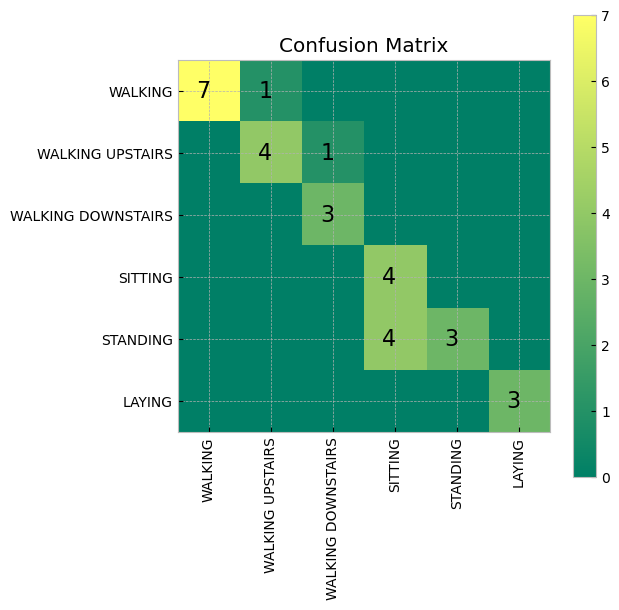

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(label, y_test[::100], target_names = [l for l in labels.values()]))
conf_mat = confusion_matrix(label, y_test[::100])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')

for i,row in enumerate(conf_mat):
    for j,c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)

cb = fig.colorbar(res)
plt.title('Confusion Matrix')
plt.xticks(range(6), [l for l in labels.values()], rotation=90)
plt.yticks(range(6), [l for l in labels.values()])

 [                  0%                  ] None
 [                  1%                  ]  2 of 200 complete None
 [*                 2%                  ]  3 of 200 complete None
 [*                 2%                  ]  4 of 200 complete None
 [*                 2%                  ]  5 of 200 complete None
 [*                 3%                  ]  6 of 200 complete None
 [**                4%                  ]  7 of 200 complete None
 [**                4%                  ]  8 of 200 complete None
 [**                4%                  ]  9 of 200 complete None
 [**                5%                  ]  10 of 200 complete None
 [**                6%                  ]  11 of 200 complete None
 [**                6%                  ]  12 of 200 complete None
 [**                6%                  ]  13 of 200 complete None
 [***               7%                  ]  14 of 200 complete None
 [***               8%                  ]  15 of 200 complete None
 [***               8% 

 [*****************62%****              ]  124 of 200 complete None
 [*****************62%****              ]  125 of 200 complete None
 [*****************63%****              ]  126 of 200 complete None
 [*****************64%****              ]  127 of 200 complete None
 [*****************64%****              ]  128 of 200 complete None
 [*****************64%****              ]  129 of 200 complete None
 [*****************65%*****             ]  130 of 200 complete None
 [*****************66%*****             ]  131 of 200 complete None
 [*****************66%*****             ]  132 of 200 complete None
 [*****************66%*****             ]  133 of 200 complete None
 [*****************67%*****             ]  134 of 200 complete None
 [*****************68%******            ]  135 of 200 complete None
 [*****************68%******            ]  136 of 200 complete None
 [*****************68%******            ]  137 of 200 complete None
 [*****************69%******            ]  138 o

 [*********        23%                  ]  46 of 200 complete None
 [*********        24%                  ]  47 of 200 complete None
 [*********        24%                  ]  48 of 200 complete None
 [*********        24%                  ]  49 of 200 complete None
 [**********       25%                  ]  50 of 200 complete None
 [**********       26%                  ]  51 of 200 complete None
 [**********       26%                  ]  52 of 200 complete None
 [**********       26%                  ]  53 of 200 complete None
 [**********       27%                  ]  54 of 200 complete None
 [***********      28%                  ]  55 of 200 complete None
 [***********      28%                  ]  56 of 200 complete None
 [***********      28%                  ]  57 of 200 complete None
 [***********      29%                  ]  58 of 200 complete None
 [***********      30%                  ]  59 of 200 complete None
 [***********      30%                  ]  60 of 200 complete 

 [*****************84%************      ]  168 of 200 complete None
 [*****************84%************      ]  169 of 200 complete None
 [*****************85%************      ]  170 of 200 complete None
 [*****************86%*************     ]  171 of 200 complete None
 [*****************86%*************     ]  172 of 200 complete None
 [*****************86%*************     ]  173 of 200 complete None
 [*****************87%*************     ]  174 of 200 complete None
 [*****************88%*************     ]  175 of 200 complete None
 [*****************88%*************     ]  176 of 200 complete None
 [*****************88%*************     ]  177 of 200 complete None
 [*****************89%**************    ]  178 of 200 complete None
 [*****************90%**************    ]  179 of 200 complete None
 [*****************90%**************    ]  180 of 200 complete None
 [*****************90%**************    ]  181 of 200 complete None
 [*****************91%***************   ]  182 o

 [*****************46%                  ]  91 of 200 complete None
 [*****************46%                  ]  92 of 200 complete None
 [*****************46%                  ]  93 of 200 complete None
 [*****************47%                  ]  94 of 200 complete None
 [*****************48%                  ]  95 of 200 complete None
 [*****************48%                  ]  96 of 200 complete None
 [*****************48%                  ]  97 of 200 complete None
 [*****************49%                  ]  98 of 200 complete None
 [*****************50%                  ]  99 of 200 complete None
 [*****************50%                  ]  100 of 200 complete None
 [*****************50%                  ]  101 of 200 complete None
 [*****************51%                  ]  102 of 200 complete None
 [*****************52%                  ]  103 of 200 complete None
 [*****************52%                  ]  104 of 200 complete None
 [*****************52%                  ]  105 of 200 com

 [**                6%                  ]  13 of 200 complete None
 [***               7%                  ]  14 of 200 complete None
 [***               8%                  ]  15 of 200 complete None
 [***               8%                  ]  16 of 200 complete None
 [***               8%                  ]  17 of 200 complete None
 [***               9%                  ]  18 of 200 complete None
 [****             10%                  ]  19 of 200 complete None
 [****             10%                  ]  20 of 200 complete None
 [****             10%                  ]  21 of 200 complete None
 [****             11%                  ]  22 of 200 complete None
 [*****            12%                  ]  23 of 200 complete None
 [*****            12%                  ]  24 of 200 complete None
 [*****            12%                  ]  25 of 200 complete None
 [*****            13%                  ]  26 of 200 complete None
 [*****            14%                  ]  27 of 200 complete 

 [*****************68%******            ]  135 of 200 complete None
 [*****************68%******            ]  136 of 200 complete None
 [*****************68%******            ]  137 of 200 complete None
 [*****************69%******            ]  138 of 200 complete None
 [*****************70%*******           ]  139 of 200 complete None
 [*****************70%*******           ]  140 of 200 complete None
 [*****************70%*******           ]  141 of 200 complete None
 [*****************71%*******           ]  142 of 200 complete None
 [*****************72%*******           ]  143 of 200 complete None
 [*****************72%*******           ]  144 of 200 complete None
 [*****************72%*******           ]  145 of 200 complete None
 [*****************73%********          ]  146 of 200 complete None
 [*****************74%********          ]  147 of 200 complete None
 [*****************74%********          ]  148 of 200 complete None
 [*****************74%********          ]  149 o

 [***********      28%                  ]  57 of 200 complete None
 [***********      29%                  ]  58 of 200 complete None
 [***********      30%                  ]  59 of 200 complete None
 [***********      30%                  ]  60 of 200 complete None
 [***********      30%                  ]  61 of 200 complete None
 [************     31%                  ]  62 of 200 complete None
 [************     32%                  ]  63 of 200 complete None
 [************     32%                  ]  64 of 200 complete None
 [************     32%                  ]  65 of 200 complete None
 [*************    33%                  ]  66 of 200 complete None
 [*************    34%                  ]  67 of 200 complete None
 [*************    34%                  ]  68 of 200 complete None
 [*************    34%                  ]  69 of 200 complete None
 [*************    35%                  ]  70 of 200 complete None
 [**************   36%                  ]  71 of 200 complete 

 [*****************90%**************    ]  179 of 200 complete None
 [*****************90%**************    ]  180 of 200 complete None
 [*****************90%**************    ]  181 of 200 complete None
 [*****************91%***************   ]  182 of 200 complete None
 [*****************92%***************   ]  183 of 200 complete None
 [*****************92%***************   ]  184 of 200 complete None
 [*****************92%***************   ]  185 of 200 complete None
 [*****************93%***************   ]  186 of 200 complete None
 [*****************94%****************  ]  187 of 200 complete None
 [*****************94%****************  ]  188 of 200 complete None
 [*****************94%****************  ]  189 of 200 complete None
 [*****************95%****************  ]  190 of 200 complete None
 [*****************96%****************  ]  191 of 200 complete None
 [*****************96%****************  ]  192 of 200 complete None
 [*****************96%****************  ]  193 o

 [*****************51%                  ]  102 of 200 complete None
 [*****************52%                  ]  103 of 200 complete None
 [*****************52%                  ]  104 of 200 complete None
 [*****************52%                  ]  105 of 200 complete None
 [*****************53%                  ]  106 of 200 complete None
 [*****************54%*                 ]  107 of 200 complete None
 [*****************54%*                 ]  108 of 200 complete None
 [*****************55%*                 ]  109 of 200 complete None
 [*****************55%*                 ]  110 of 200 complete None
 [*****************56%*                 ]  111 of 200 complete None
 [*****************56%*                 ]  112 of 200 complete None
 [*****************56%*                 ]  113 of 200 complete None
 [*****************57%**                ]  114 of 200 complete None
 [*****************57%**                ]  115 of 200 complete None
 [*****************58%**                ]  116 o

 [*****            12%                  ]  24 of 200 complete None
 [*****            12%                  ]  25 of 200 complete None
 [*****            13%                  ]  26 of 200 complete None
 [*****            14%                  ]  27 of 200 complete None
 [*****            14%                  ]  28 of 200 complete None
 [*****            14%                  ]  29 of 200 complete None
 [******           15%                  ]  30 of 200 complete None
 [******           16%                  ]  31 of 200 complete None
 [******           16%                  ]  32 of 200 complete None
 [******           16%                  ]  33 of 200 complete None
 [******           17%                  ]  34 of 200 complete None
 [*******          18%                  ]  35 of 200 complete None
 [*******          18%                  ]  36 of 200 complete None
 [*******          18%                  ]  37 of 200 complete None
 [*******          19%                  ]  38 of 200 complete 

 [*****************73%********          ]  146 of 200 complete None
 [*****************74%********          ]  147 of 200 complete None
 [*****************74%********          ]  148 of 200 complete None
 [*****************74%********          ]  149 of 200 complete None
 [*****************75%********          ]  150 of 200 complete None
 [*****************76%*********         ]  151 of 200 complete None
 [*****************76%*********         ]  152 of 200 complete None
 [*****************76%*********         ]  153 of 200 complete None
 [*****************77%*********         ]  154 of 200 complete None
 [*****************78%**********        ]  155 of 200 complete None
 [*****************78%**********        ]  156 of 200 complete None
 [*****************78%**********        ]  157 of 200 complete None
 [*****************79%**********        ]  158 of 200 complete None
 [*****************80%**********        ]  159 of 200 complete None
 [*****************80%**********        ]  160 o

 [*************    34%                  ]  68 of 200 complete None
 [*************    34%                  ]  69 of 200 complete None
 [*************    35%                  ]  70 of 200 complete None
 [**************   36%                  ]  71 of 200 complete None
 [**************   36%                  ]  72 of 200 complete None
 [**************   36%                  ]  73 of 200 complete None
 [**************   37%                  ]  74 of 200 complete None
 [**************   38%                  ]  75 of 200 complete None
 [**************   38%                  ]  76 of 200 complete None
 [**************   38%                  ]  77 of 200 complete None
 [***************  39%                  ]  78 of 200 complete None
 [***************  40%                  ]  79 of 200 complete None
 [***************  40%                  ]  80 of 200 complete None
 [***************  40%                  ]  81 of 200 complete None
 [**************** 41%                  ]  82 of 200 complete 

 [*****************94%****************  ]  189 of 200 complete None
 [*****************95%****************  ]  190 of 200 complete None
 [*****************96%****************  ]  191 of 200 complete None
 [*****************96%****************  ]  192 of 200 complete None
 [*****************96%****************  ]  193 of 200 complete None
 [*****************97%***************** ]  194 of 200 complete None
 [*****************98%***************** ]  195 of 200 complete None
 [*****************98%***************** ]  196 of 200 complete None
 [*****************98%***************** ]  197 of 200 complete None
 [*****************99%******************]  198 of 200 complete None
 [****************100%******************]  199 of 200 complete None
 [****************100%******************]  200 of 200 complete None
 [                  0%                  ] None
 [                  1%                  ]  2 of 200 complete None
 [*                 2%                  ]  3 of 200 complete None
 [*  

 [*****************56%*                 ]  112 of 200 complete None
 [*****************56%*                 ]  113 of 200 complete None
 [*****************57%**                ]  114 of 200 complete None
 [*****************57%**                ]  115 of 200 complete None
 [*****************58%**                ]  116 of 200 complete None
 [*****************58%**                ]  117 of 200 complete None
 [*****************59%**                ]  118 of 200 complete None
 [*****************60%***               ]  119 of 200 complete None
 [*****************60%***               ]  120 of 200 complete None
 [*****************60%***               ]  121 of 200 complete None
 [*****************61%***               ]  122 of 200 complete None
 [*****************62%****              ]  123 of 200 complete None
 [*****************62%****              ]  124 of 200 complete None
 [*****************62%****              ]  125 of 200 complete None
 [*****************63%****              ]  126 o

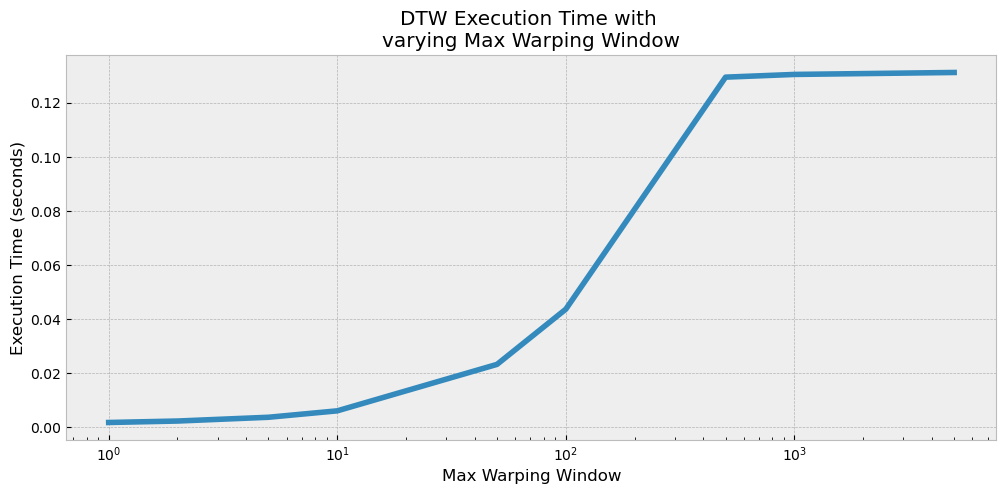

In [48]:
import time

time_taken = []
windows = [1,2,5,10,50,100,500,1000,5000]

for w in windows:
    begin = time.time()
    
    t = KnnDtw(n_neighbors = 1, max_warping_window = w)
    t.fit(x_train[:20], y_train[:20])
    label, proba = t.predict(x_test[:20])
    
    end = time.time()
    time_taken.append(end-begin)

fig = plt.figure(figsize=(12,5))
plt.plot(windows, [t/400. for t in time_taken], lw=4)
plt.title('DTW Execution Time with \nvarying Max Warping Window')
plt.ylabel('Execution Time (seconds)')
plt.xlabel('Max Warping Window')
plt.xscale('log')